In [1]:
import math
import random
import unittest
import sys
import math
import os
import time
import seaborn as sns
import matplotlib
import pandas as pd
import sympy
import matplotlib.pyplot as plt
import sciplot
import numpy as np 


from clock import Clock
from fifo import Fifo, FifoEmpty
from sdram import Sdram


BL = 8
S_IN = 1600e6 / BL
# T_CK = 1 / 1600e6 * 2
T_CK = 1 / S_IN / 4
T_RCD = 7 * T_CK
T_RP = 7 * T_CK
T_CL = 7 * T_CK
T_CCD = 4 * T_CK
T_RTP = max(4 * T_CK, 7.5e-9)
T_RFC = 350e-9

T_IN = 1 / S_IN
T_SW = math.ceil((T_RTP + T_RP + T_RCD - T_CCD) / T_IN) * T_IN
# T_SW = 60e-9
T_RTI = math.ceil((T_SW + T_RFC) / T_IN) * T_IN
# T_RTI = 360e-9
T_REFI = math.floor(7.8e-6 / T_IN) * T_IN

N_NUM = 3000

In [2]:
def k_div_n__and__n_fifo_relation(N = 11, K = 1, times = 300):
    plt.style.use(['science','ieee'])
    d = {'k/n': [], 'n': [], "s_out": [], "n_fifo": []}
    k1 = K
    n1 = N
    for i in range(times):
        K = k1 + i
        N = n1
        r = sympy.Rational(K, N)
        K = r.p
        N = r.q

        S_OUT = (N * T_REFI - K * T_SW - N * T_RTI) / \
            (N * T_REFI) * S_IN  # 64byte

        N_FIFO = math.ceil(
            T_SW * S_OUT + (T_SW * S_OUT + T_SW * S_IN + T_RTI * S_OUT if N != 1 else T_RTI * S_OUT)
        )  
        T_SEQ = (N * T_REFI - K * T_SW - N * T_RTI) / K  # sec
        N_SEQ = math.ceil(T_SEQ * S_IN)  # 64byte

        d['k/n'].append(K/N)
        d['n'].append(N_SEQ)
        d['s_out'].append(S_OUT)
        d['n_fifo'].append(N_FIFO)
    # df = pd.DataFrame(data=d)
    
    # sns.set_theme()
    # sns.set_style("ticks")
    # plt.style.use(['science','ieee'])
    # sns.relplot(data=df, x='k/n', y='n_fifo', kind="line").set_axis_labels("Timepoint", "Percent signal change")
    # fig, ax = plt.subplots() 
    # ax.plot(d['k/n'], d["n_fifo"])
    # ax.set_xlabel("Timepoint")
    # ax.set_ylabel("Percent signal change")
    return d

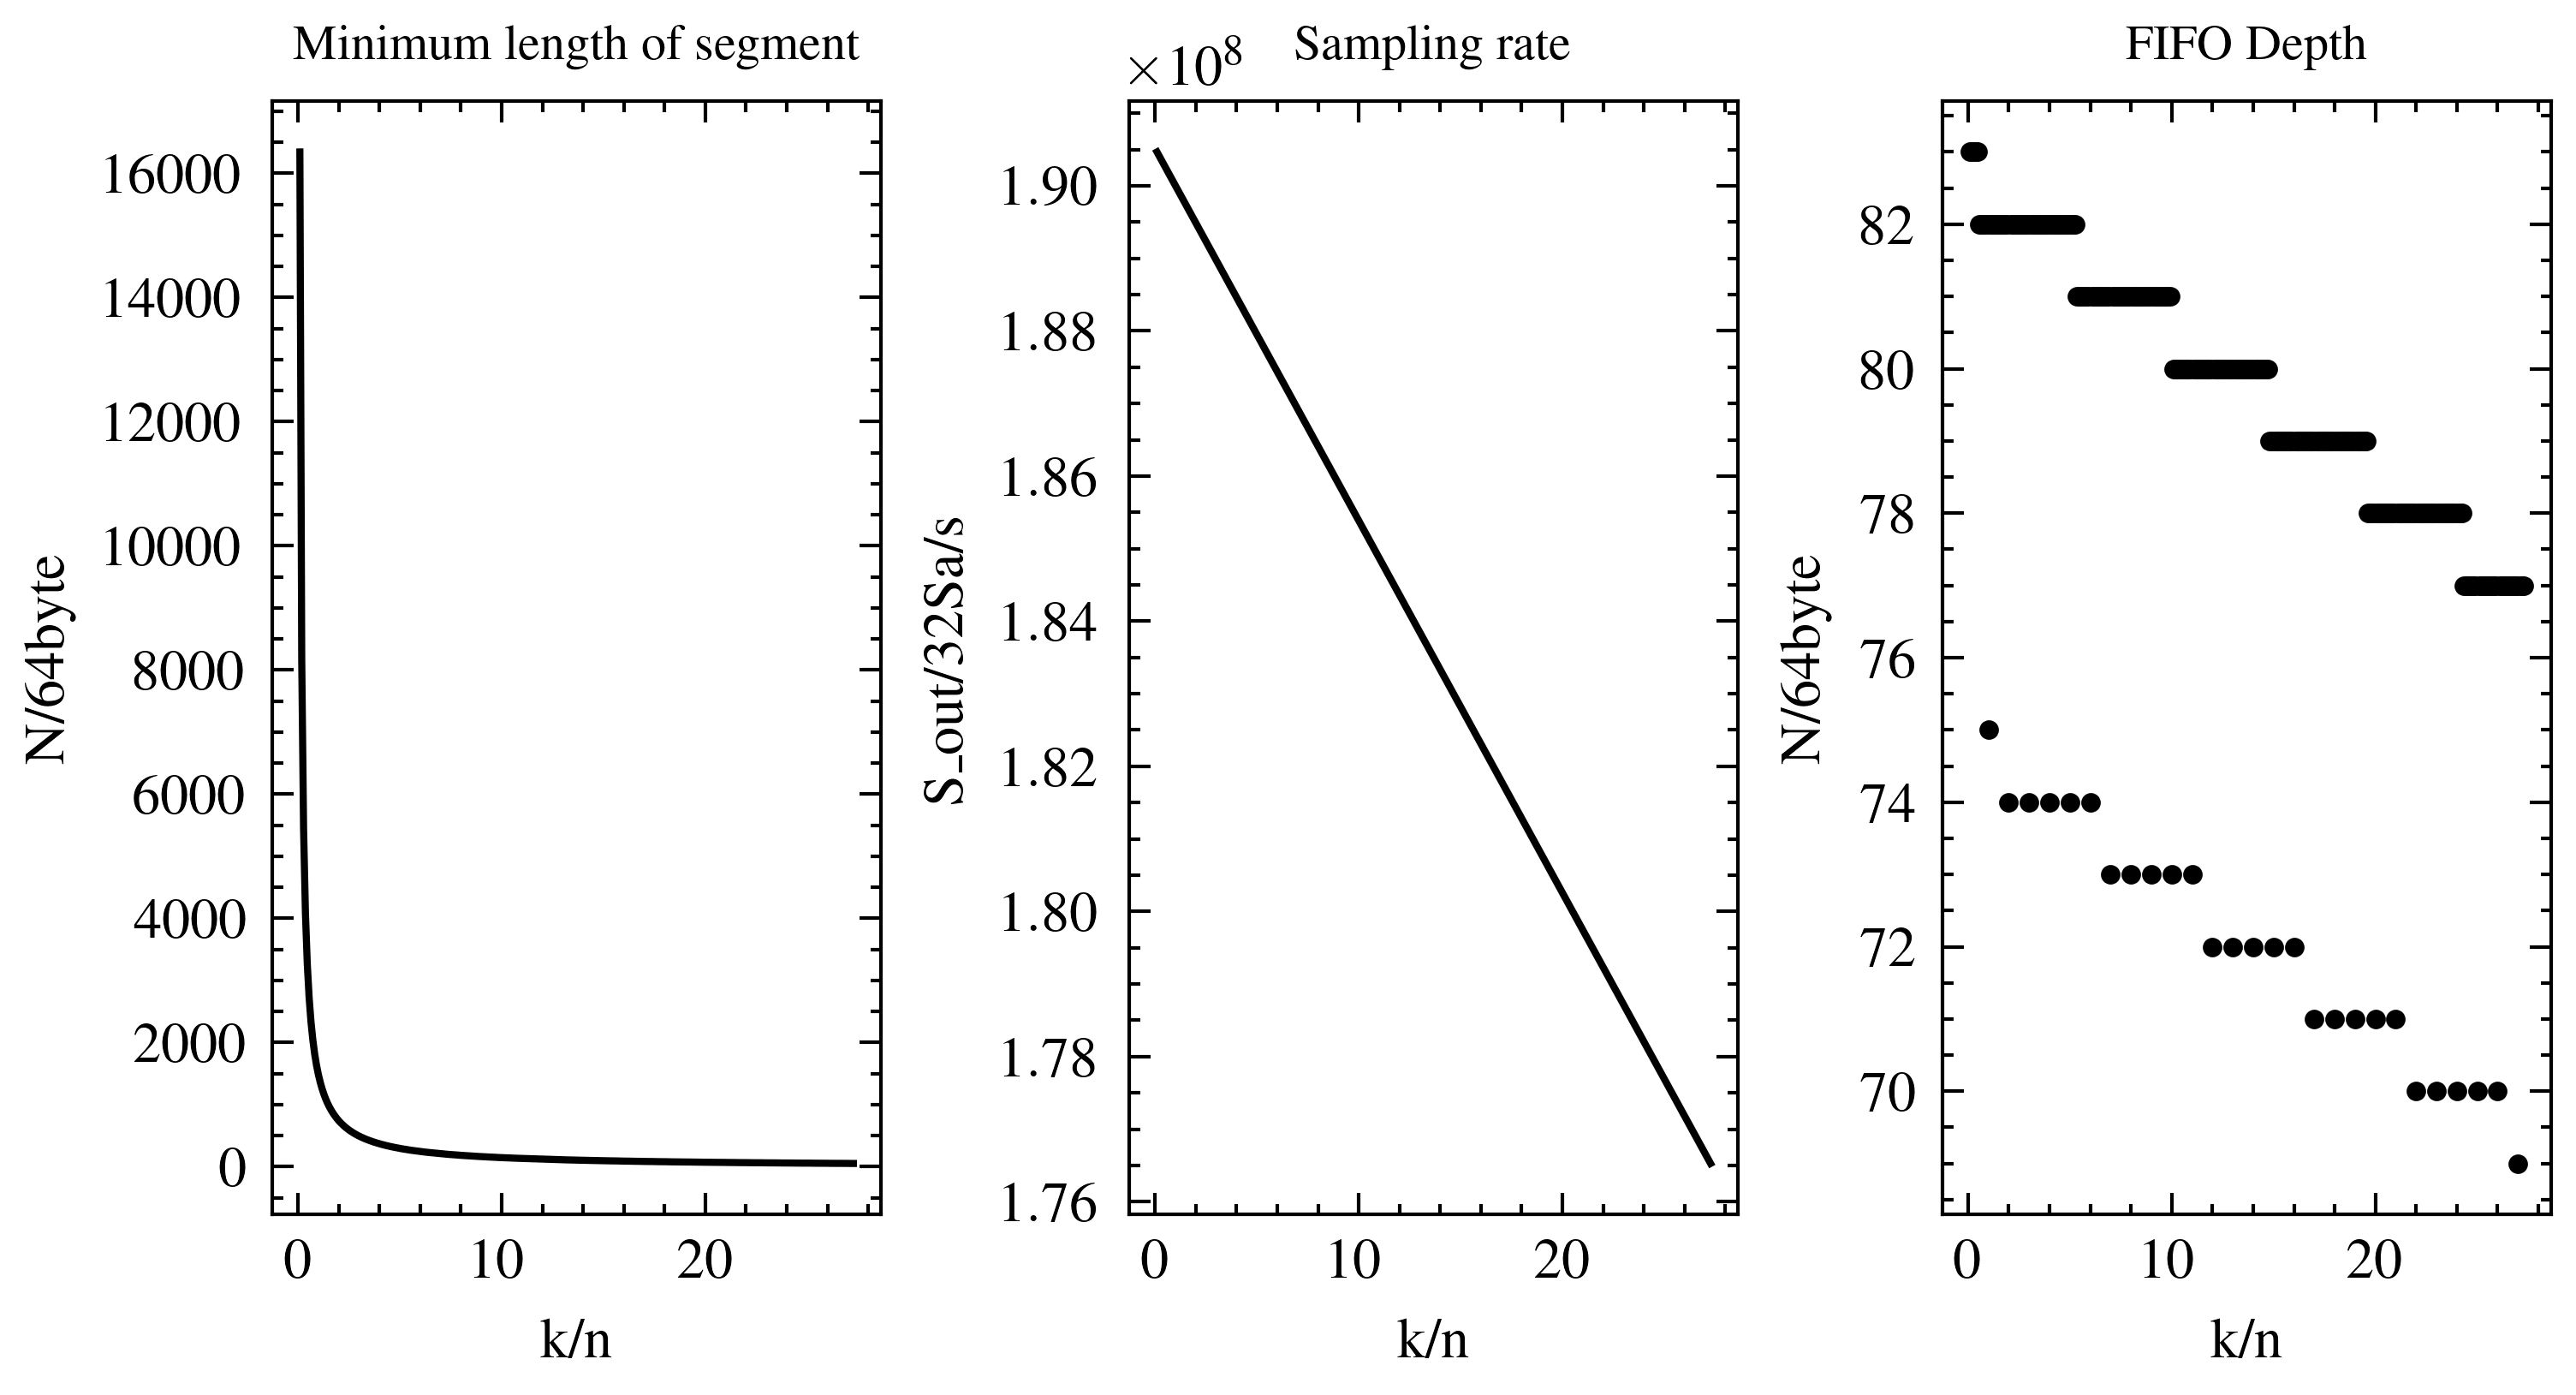

In [14]:
d = k_div_n__and__n_fifo_relation()
kn = np.array(d["k/n"])
nf = np.array(d["n"])
ds = np.array(d['s_out'])
dnf = np.array(d['n_fifo'])
fig, axs = plt.subplots(1, 3, figsize=(5, 2.7), layout='constrained')
axs[0].plot(kn, nf)
axs[0].set_xlabel("k/n")
axs[0].set_ylabel("N/64byte")
axs[0].set_title("Minimum length of segment", fontsize=7)
axs[1].plot(kn, ds)
axs[1].set_xlabel("k/n")
axs[1].set_ylabel("S_out/32Sa/s")
axs[1].set_title("Sampling rate", fontsize=7)
axs[2].scatter(kn, dnf, s = 3)
axs[2].set_xlabel("k/n")
axs[2].set_ylabel("N/64byte")
axs[2].set_title("FIFO Depth", fontsize=7)
plt.show()

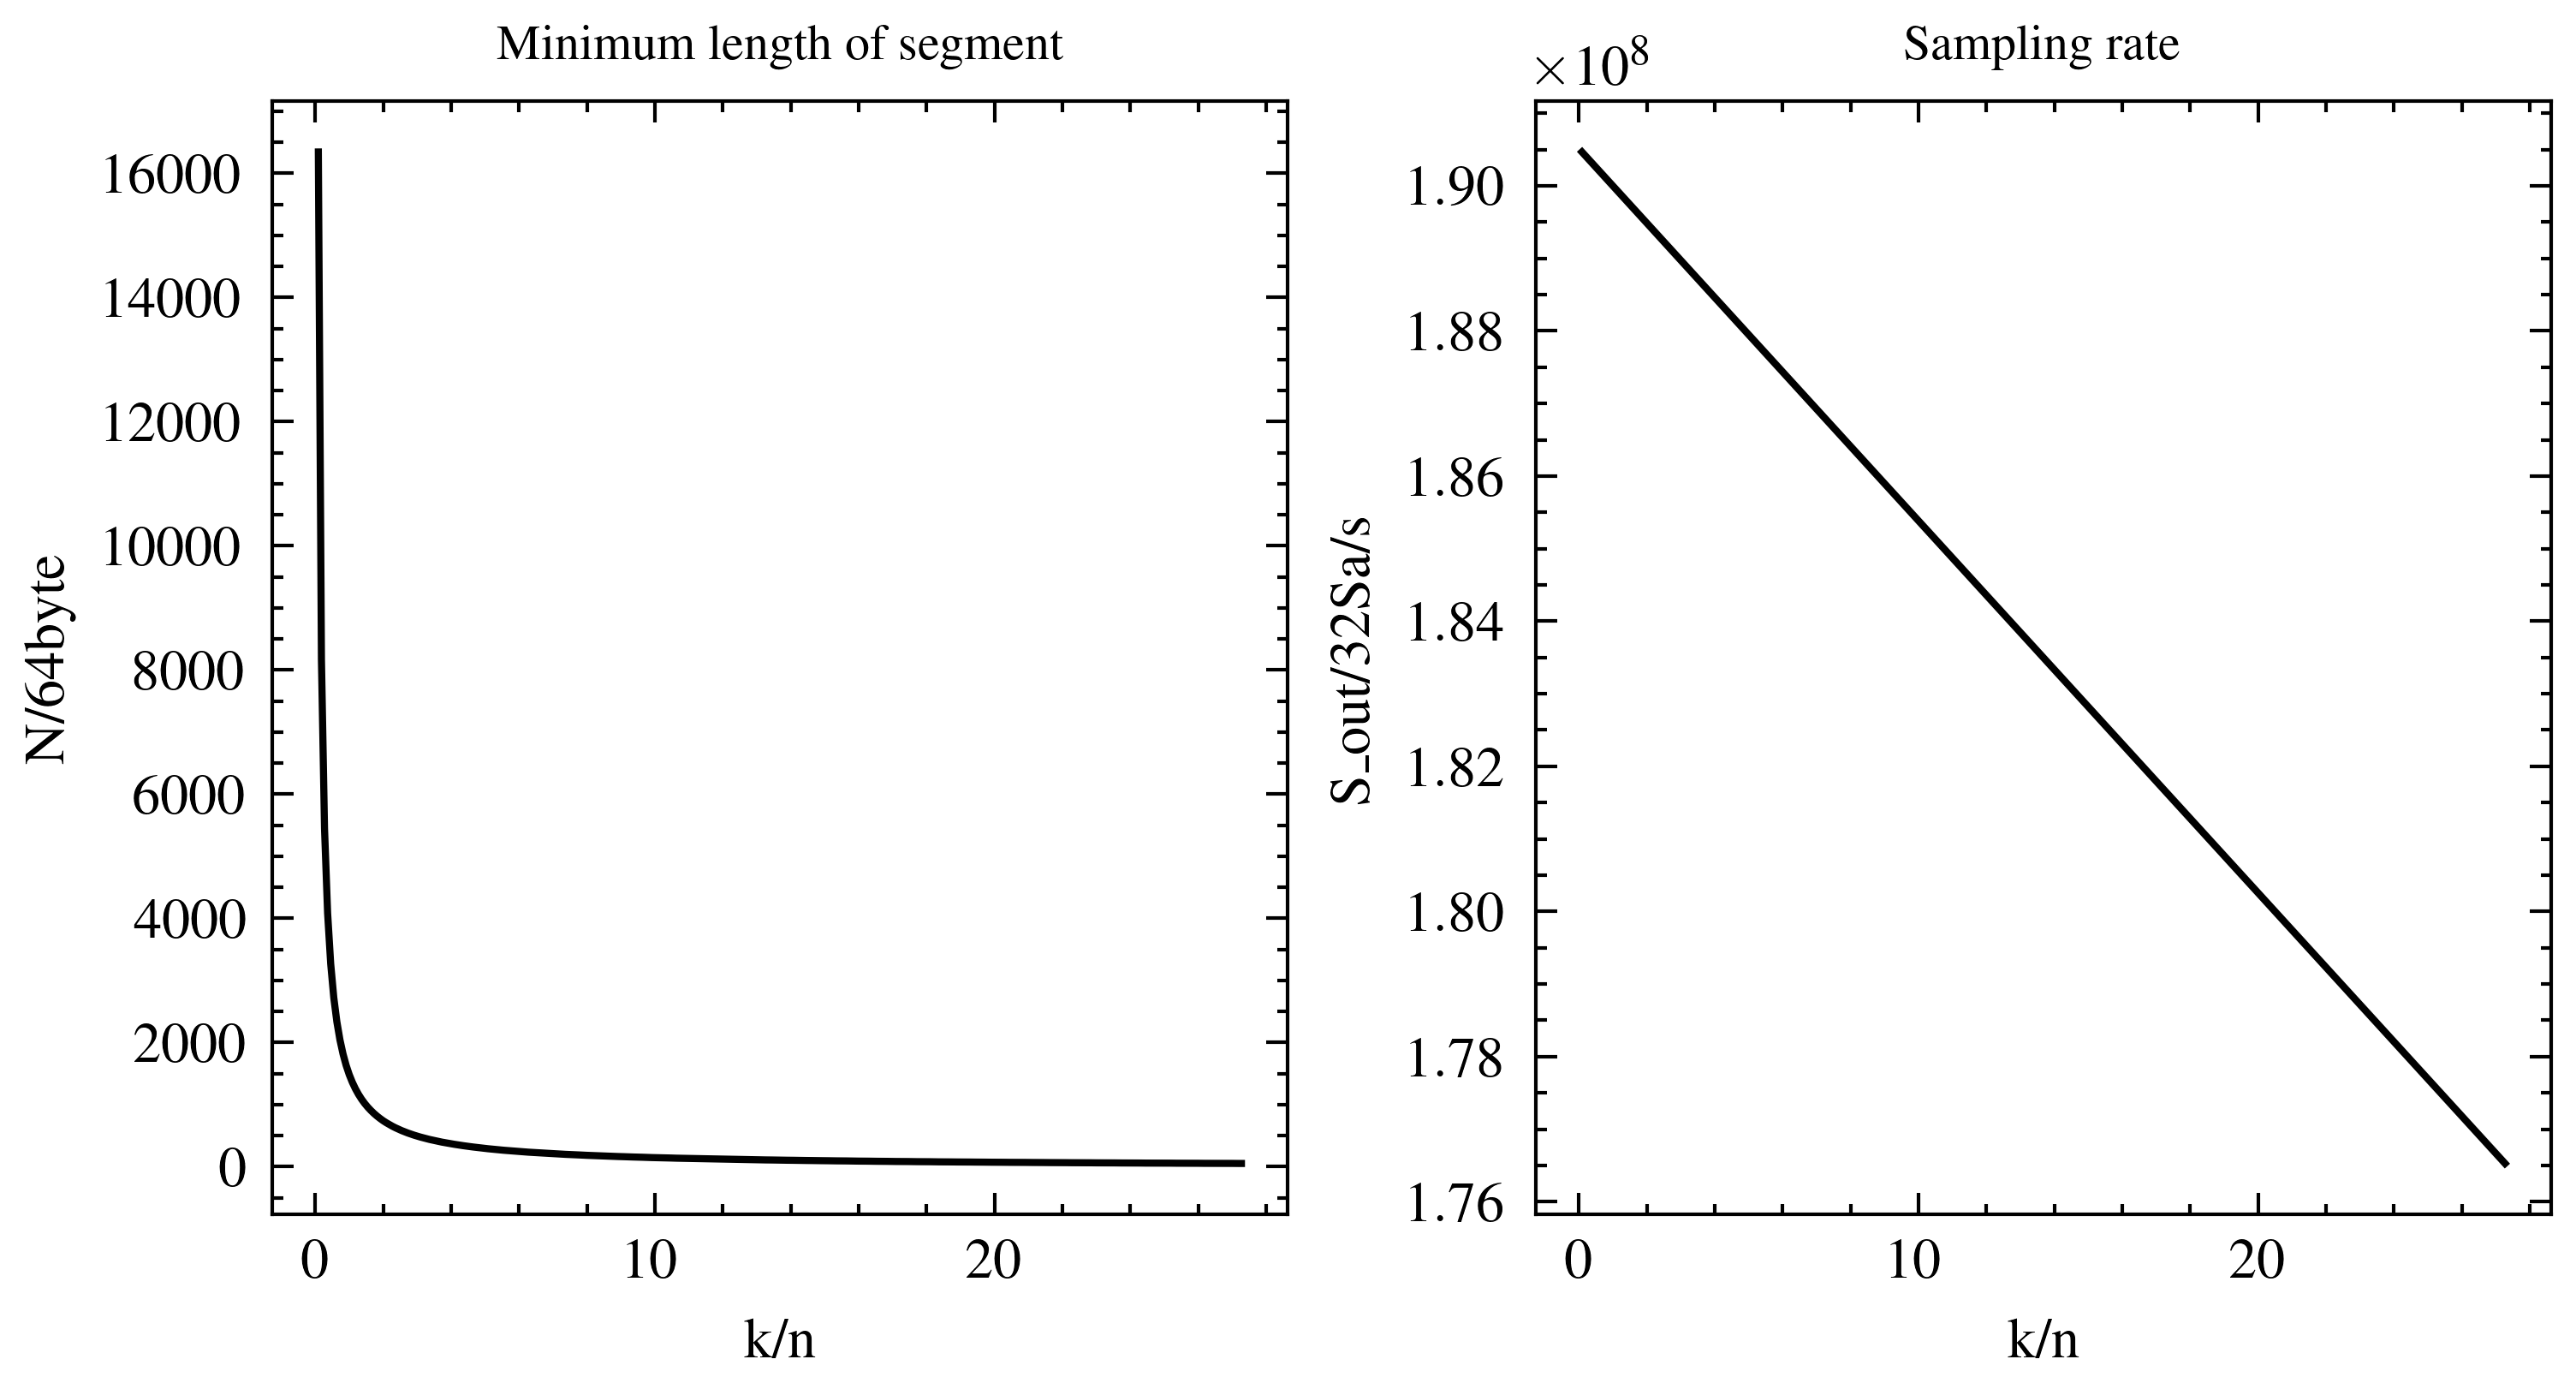

In [15]:
d = k_div_n__and__n_fifo_relation()
kn = np.array(d["k/n"])
nf = np.array(d["n"])
ds = np.array(d['s_out'])
dnf = np.array(d['n_fifo'])
fig, axs = plt.subplots(1, 2, figsize=(5, 2.7), layout='constrained')
axs[0].plot(kn, nf)
axs[0].set_xlabel("k/n")
axs[0].set_ylabel("N/64byte")
axs[0].set_title("Minimum length of segment", fontsize=7)
axs[1].plot(kn, ds)
axs[1].set_xlabel("k/n")
axs[1].set_ylabel("S_out/32Sa/s")
axs[1].set_title("Sampling rate", fontsize=7)
plt.show()

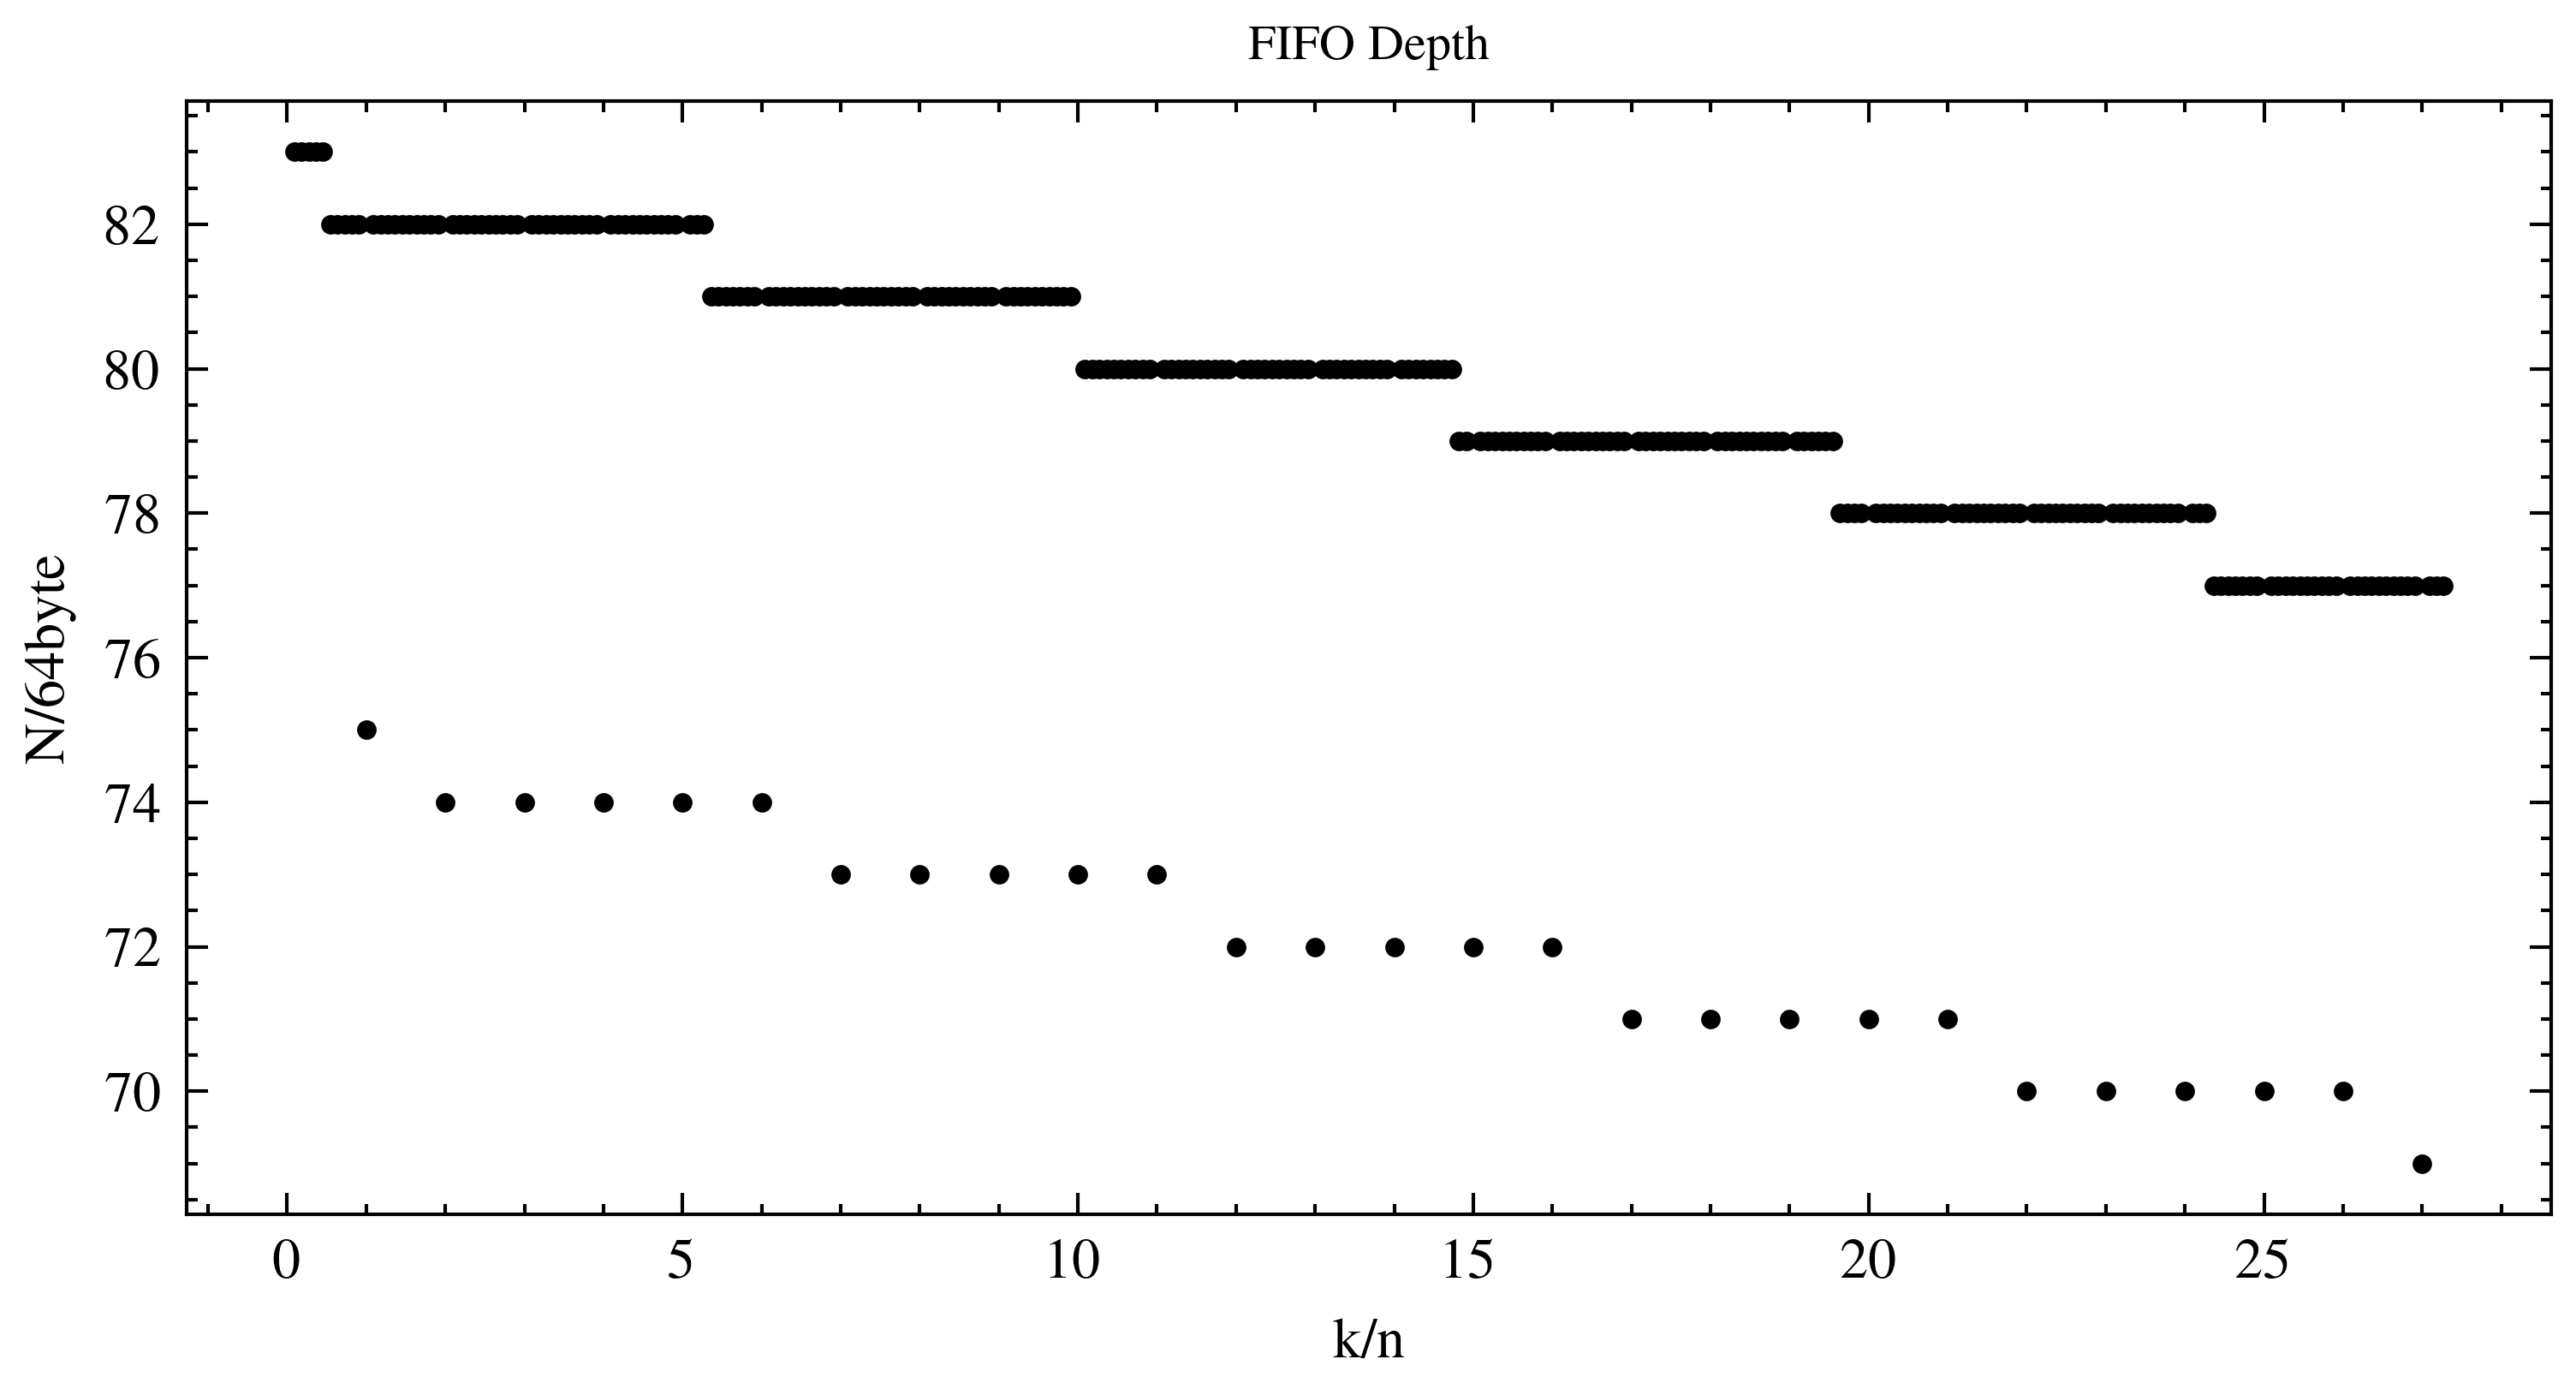

In [16]:
d = k_div_n__and__n_fifo_relation()
kn = np.array(d["k/n"])
nf = np.array(d["n"])
ds = np.array(d['s_out'])
dnf = np.array(d['n_fifo'])
fig, axs = plt.subplots(figsize=(5, 2.7), layout='constrained')
axs.scatter(kn, dnf, s = 3)
axs.set_xlabel("k/n")
axs.set_ylabel("N/64byte")
axs.set_title("FIFO Depth", fontsize=7)
plt.show()

In [3]:
def show_real_use_of_n_fifo_plot(N = 11, K = 1, k_times = 300, t_start_times = 300, step = 1):
    plt.style.use(['science','ieee'])
    # d = {'k/n': [], 'n_fifo': [], "type": []}
    d = {'k/n': [], 'n_practical': [], 'n_theoretical': []}
    # type: 1.Theoretical 2.Practical
    k1 = K
    n1 = N
    # for i in range(k_times):
    i = 0
    while(i < k_times):
        K = k1 + i
        N = n1

        i += step

        r = sympy.Rational(K, N)
        K = r.p
        N = r.q

        S_OUT = (N * T_REFI - K * T_SW - N * T_RTI) / \
                (N * T_REFI) * S_IN  # 64byte
        T_SEQ = (N * T_REFI - K * T_SW - N * T_RTI) / K  # sec
        N_SEQ = math.ceil(T_SEQ * S_IN)  # 64byte
        

        N_FIFO = math.ceil(
            T_SW * S_OUT + (T_SW * S_OUT + T_SW * S_IN + T_RTI * S_OUT if N != 1 else T_RTI * S_OUT)
        ) + 1

        d['k/n'].append(K / N)
        d['n_theoretical'].append(N_FIFO)
        # d['type'].append("Theoretical")

        n_seq = math.ceil(N_NUM / N_SEQ)
        wfm_64byte_array = [N_SEQ for i in range(n_seq)]
        fifo_in_interval = 1 / S_IN
        fifo_out_interval = 1 / S_OUT

        n_min = N_FIFO
        t_start = 0
        for j in range(t_start_times):
            t_start += T_REFI / t_start_times
            ddr_sdram = Sdram(wfm_64byte_array)
            fifo = Fifo(N_FIFO)
            clock = Clock(fifo_in_interval, fifo_out_interval,
                        T_REFI, T_SW, T_RTI, t_start)

            try:
                while(not ddr_sdram.get_finished_tranfer()):
                    clock.run()
                    fin = clock.fifo_in_finish()
                    fout = clock.fifo_out_finish()
                    ffull = fifo.is_full()

                    if fin and (not ffull):
                        ddr_sdram.send_out()
                        fifo.receive_in()

                        if ddr_sdram.get_in_sw():
                            clock.set_sw()

                    if fout:
                        fifo.send_out()

                    cur_fifo_n = fifo.get_n_64byte_fifo_current()
                    n_min = min(cur_fifo_n, n_min)
            except FifoEmpty:
                print("t_start:  %.5fns" % (t_start * 1e9))
                print("K / N:  {}".format(r))
                print("n_seq:  %d" % n_seq)
                print("n_refi:  %d" % (clock.get_current_cycle_num()))
                print("current_t:  %.5fns" % (clock.get_current_t_in_refi()))
                sys.exit()

        # d['k/n'].append(K / N)
        d['n_practical'].append(N_FIFO - n_min)
        # d['type'].append("Practical")

    # df = pd.DataFrame(data=d)
    # sns.set_theme()
    # sns.relplot(data=df, x="k/n", y="n_fifo", hue="type", style="type",kind="scatter")
    kn = np.array(d['k/n'])
    n_pa = np.array(d['n_practical'])
    n_th = np.array(d['n_theoretical'])

    fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
    ax.scatter(kn, n_pa, label="Practical", s = 0.25)
    ax.scatter(kn, n_th, label="Theoretical", s = 0.25)
    ax.set_ylabel("N/64byte")
    ax.set_xlabel("k/n")
    ax.legend()
    ax.set_title("N - k/n Plot")
    plt.show()

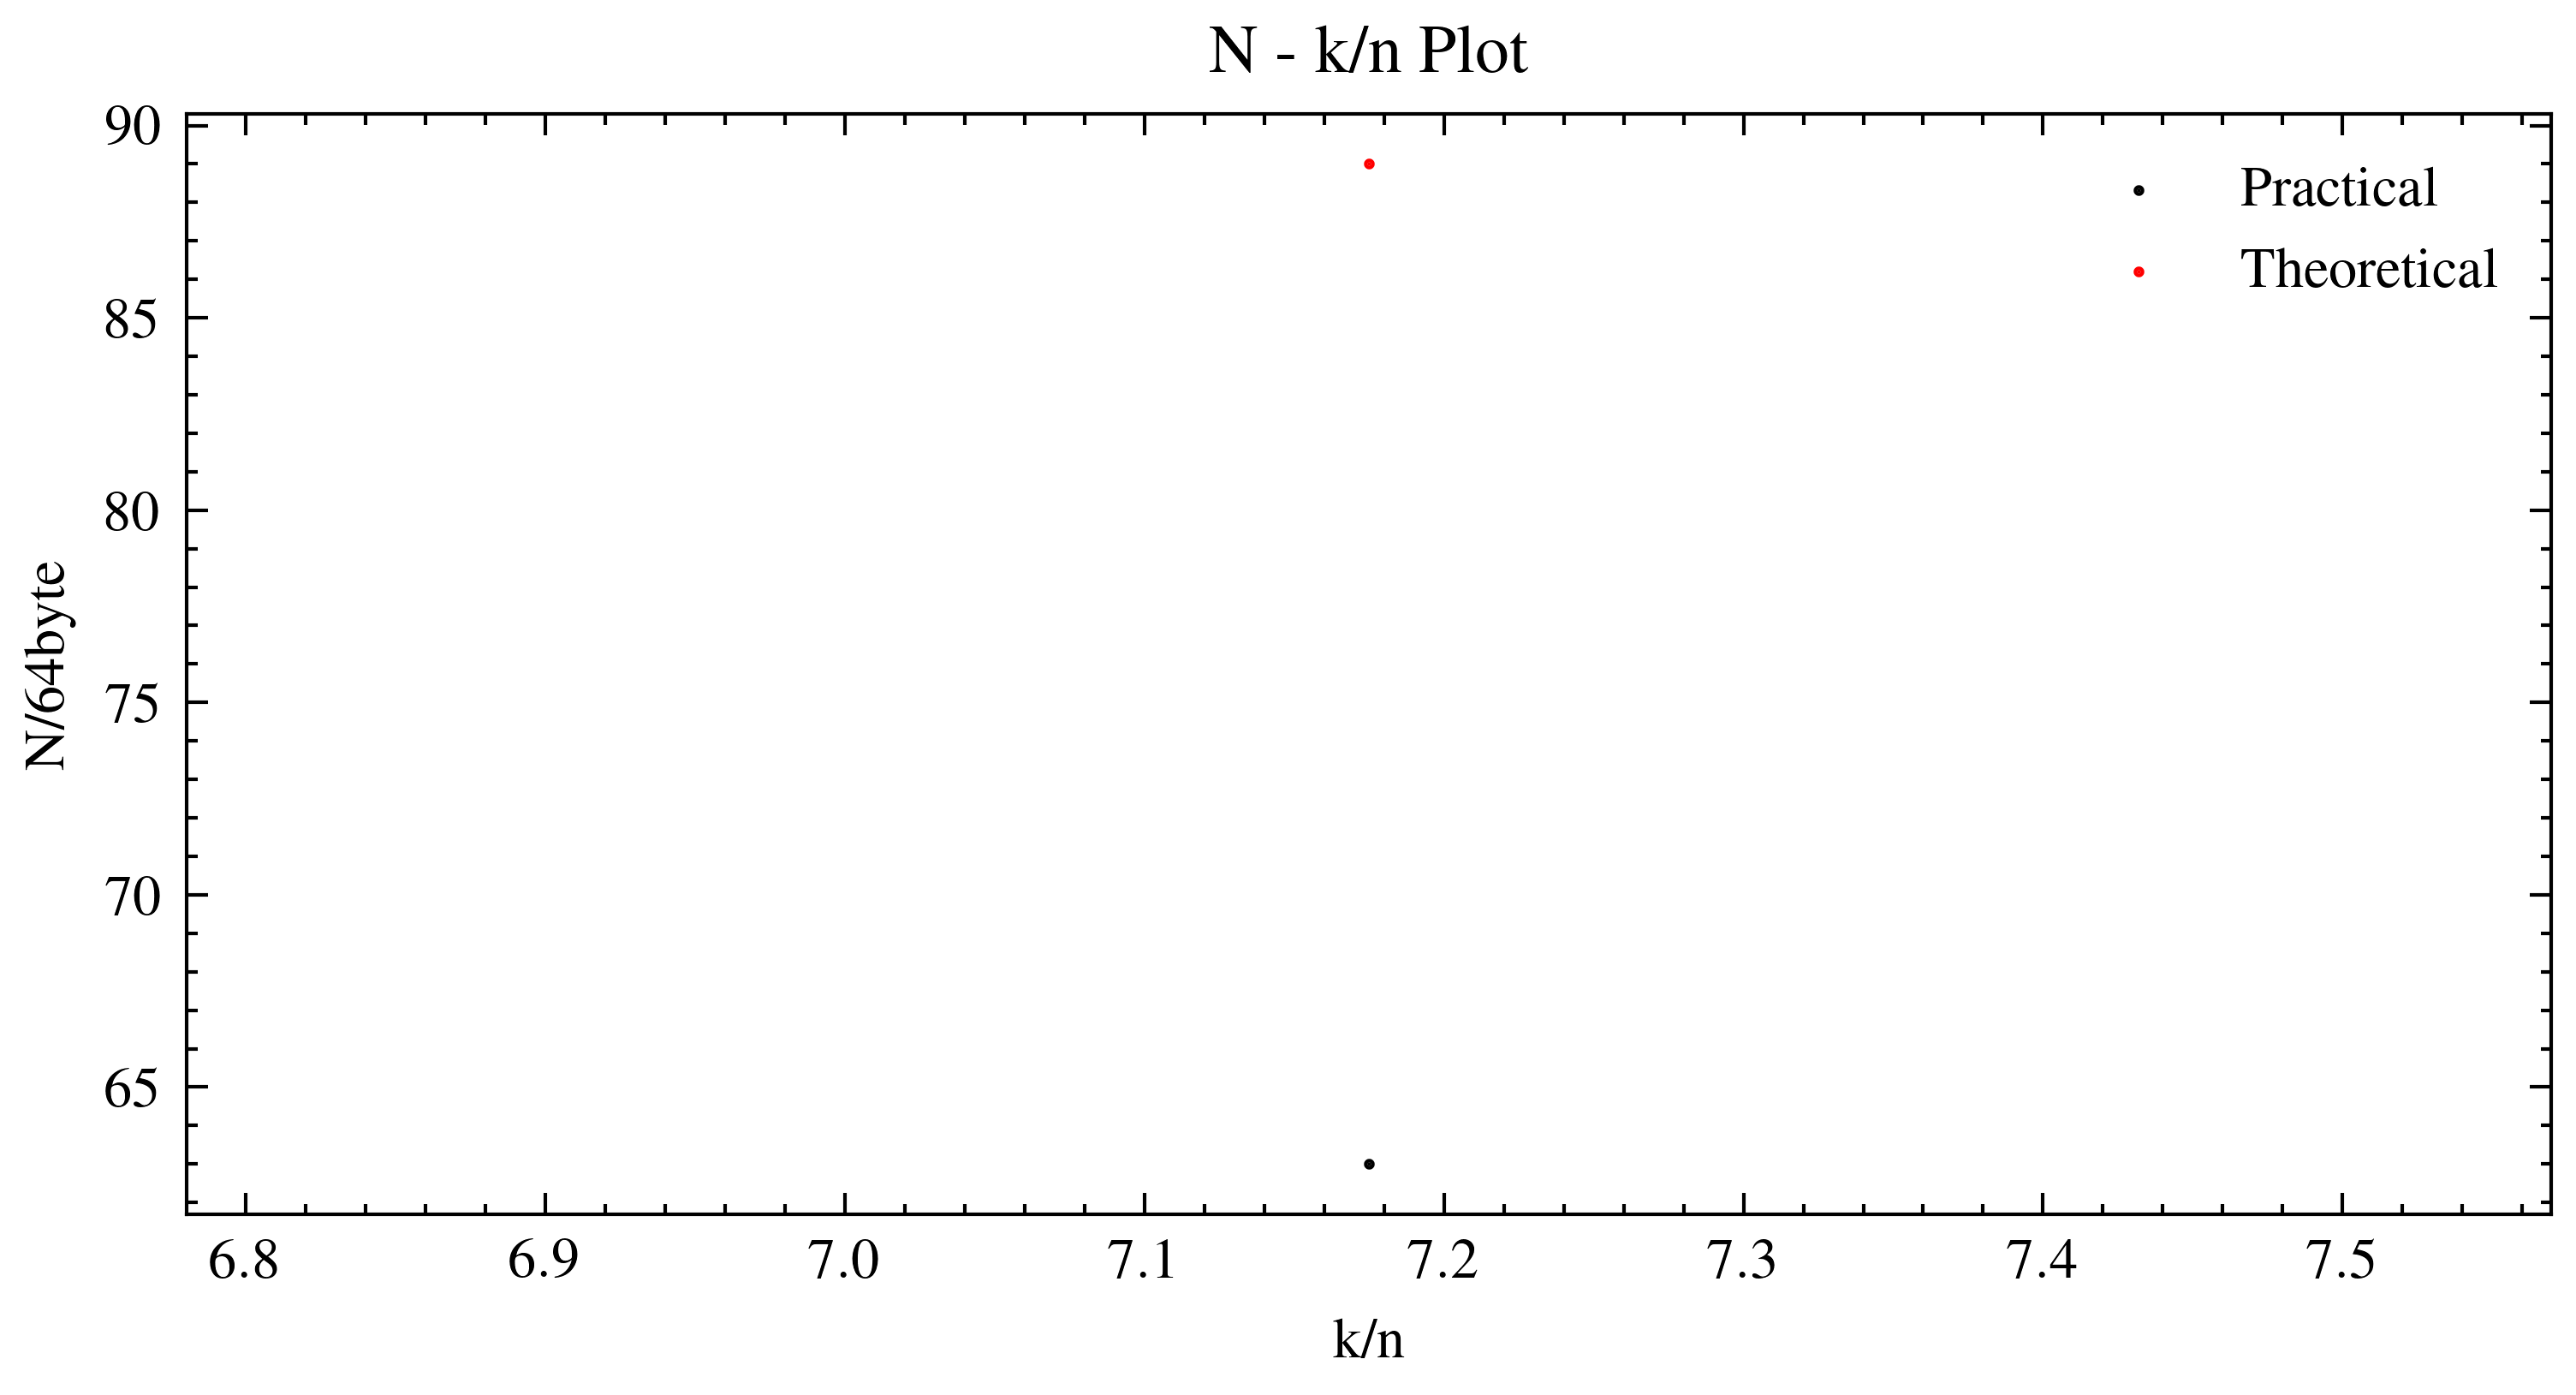

In [4]:
T_SW = 75e-9
# T_SW = 60e-9
T_RTI = 315e-9
# T_RTI = 360e-9
T_REFI = 3.9e-6

N_NUM = 30000
show_real_use_of_n_fifo_plot(N = 1, K = 7.17499999999998, k_times = 1, t_start_times = 7000, step = 1)

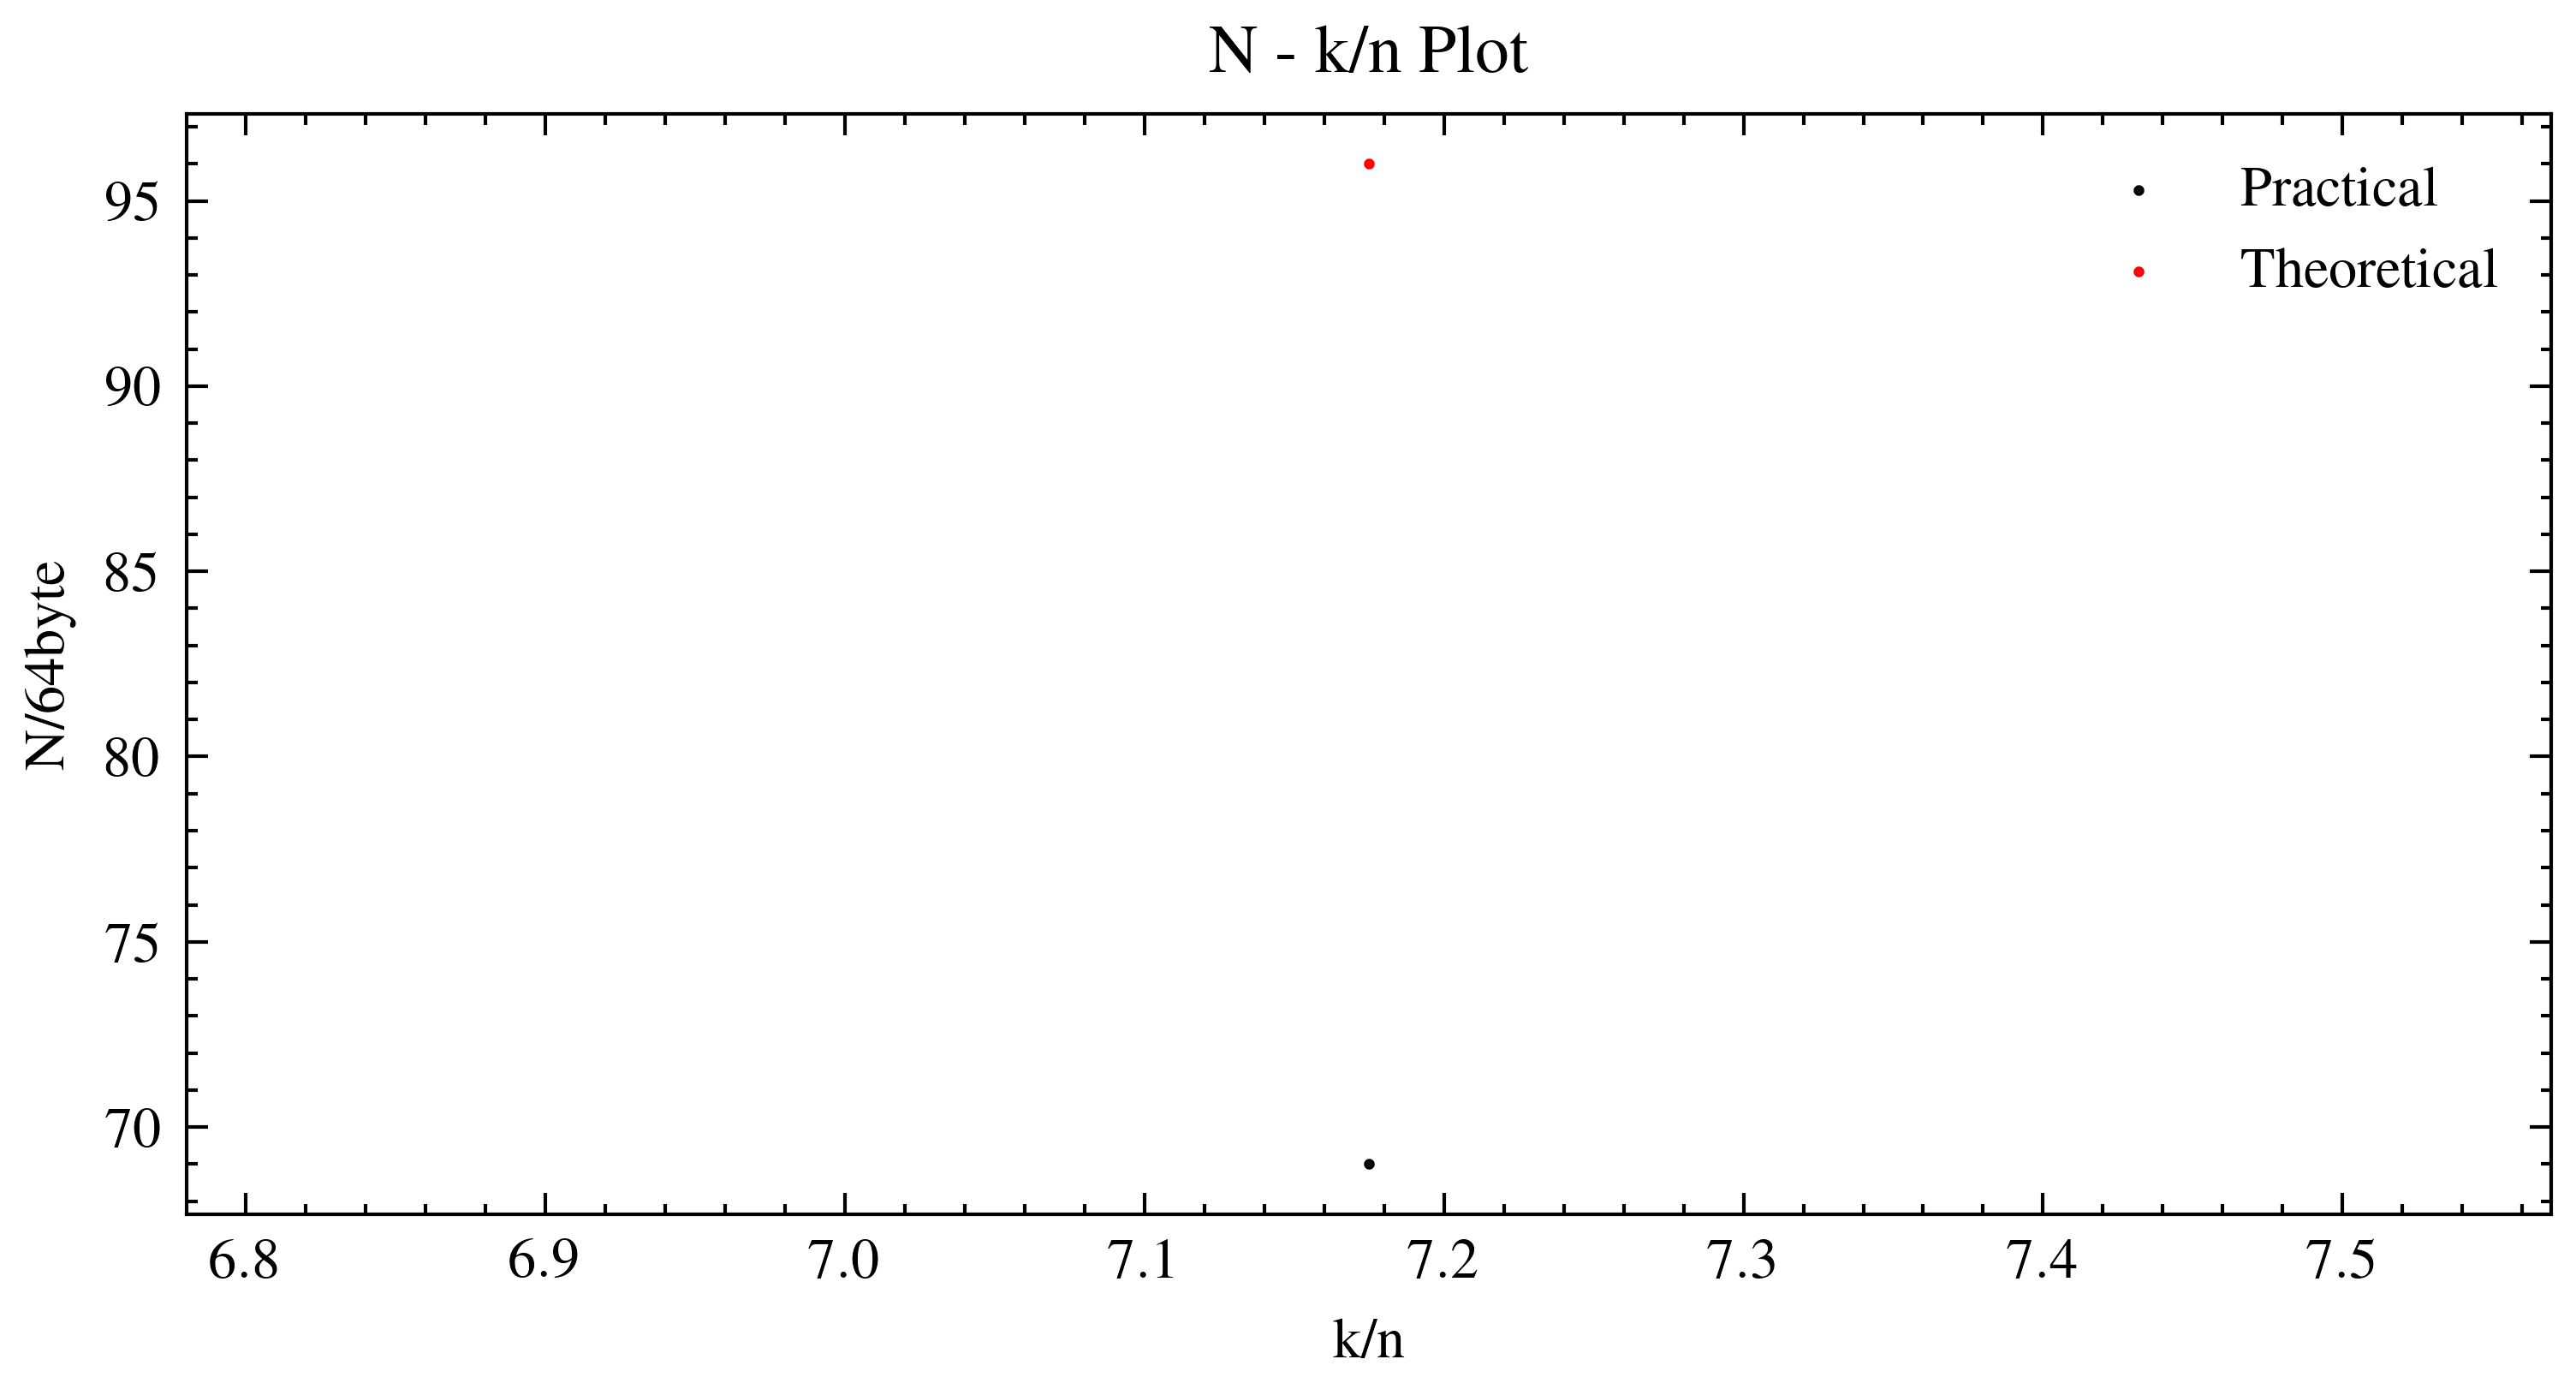

In [5]:
T_SW = 75e-9
# T_SW = 60e-9
T_RTI = 370e-9
# T_RTI = 360e-9
T_REFI = 3.9e-6

N_NUM = 30000
show_real_use_of_n_fifo_plot(N = 1, K = 7.17499999999998, k_times = 1, t_start_times = 15000, step = 1)

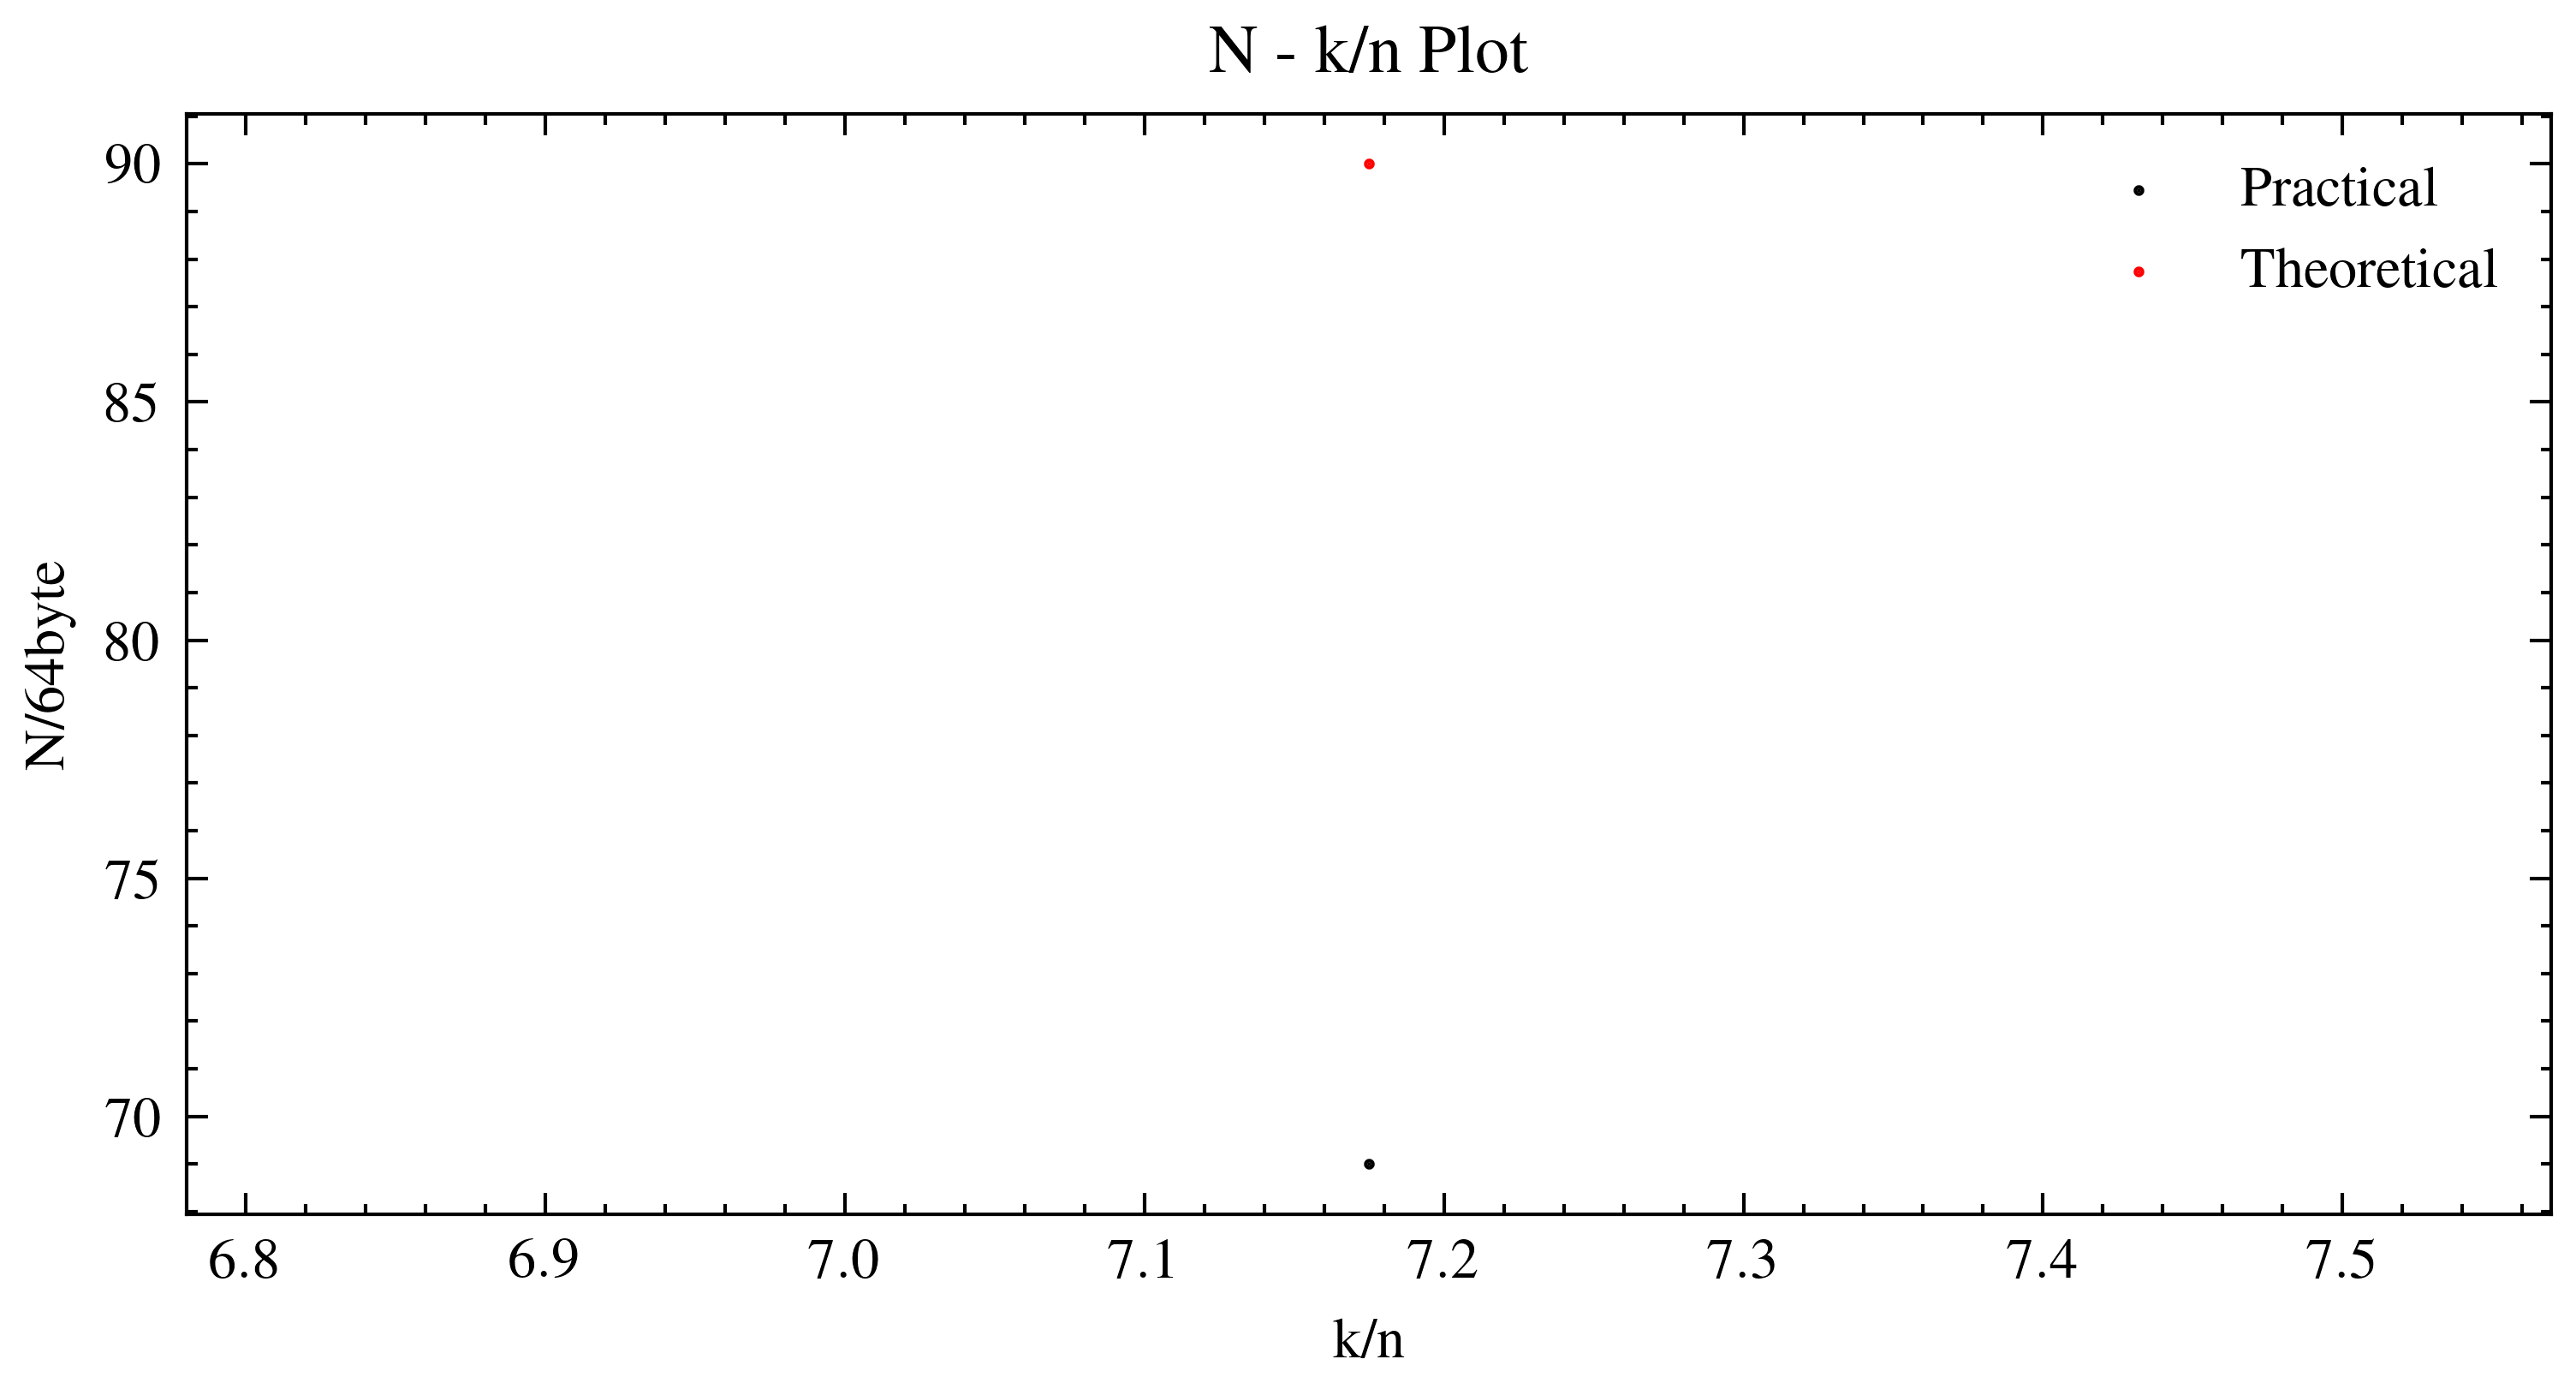

In [6]:
T_SW = 60e-9
# T_SW = 60e-9
T_RTI = 360e-9
# T_RTI = 360e-9
T_REFI = 3.9e-6

N_NUM = 30000
show_real_use_of_n_fifo_plot(N = 1, K = 7.17499999999998, k_times = 1, t_start_times = 15000, step = 1)

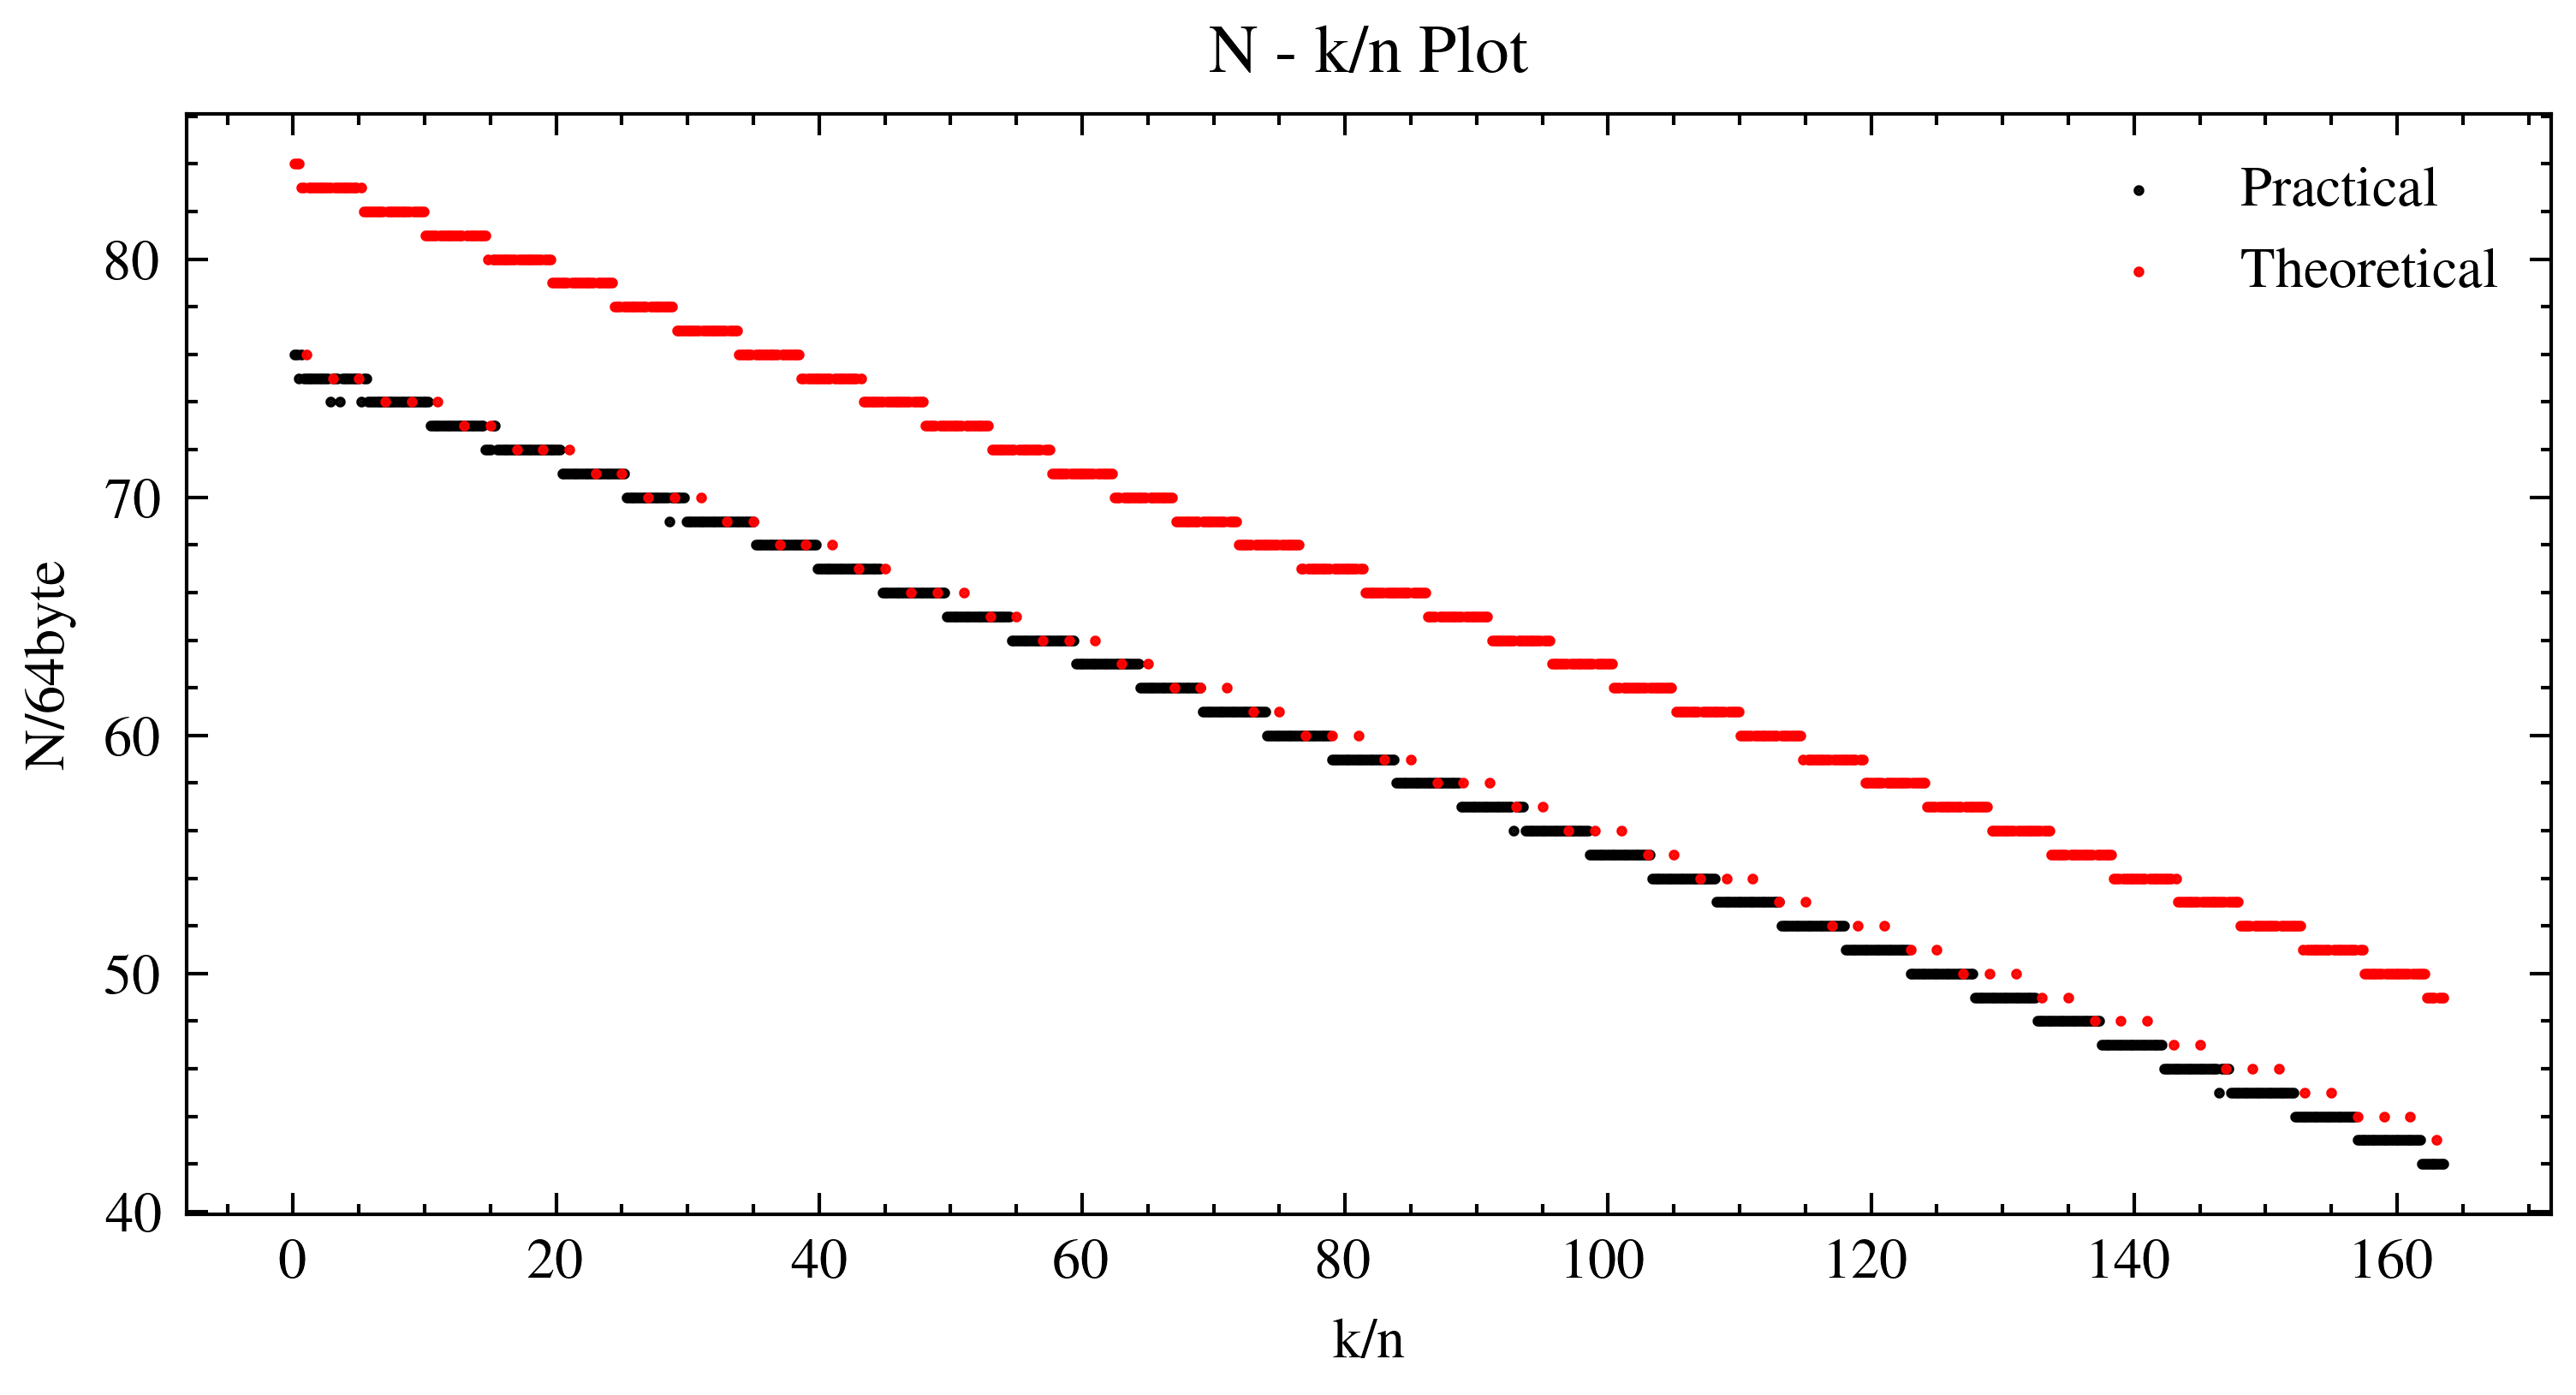

In [ ]:
show_real_use_of_n_fifo_plot(k_times = 1800, step=2)

In [6]:
T_REFI = math.floor(3.9e-6 / T_IN) * T_IN
T_SW = math.ceil((65e-9 + 7e-9) / T_IN) * T_IN
# T_SW = 60e-9
T_RTI = math.ceil((325e-9 + 7e-9) / T_IN) * T_IN
show_real_use_of_n_fifo_plot(k_times = 1800, step=2)

ZeroDivisionError: division by zero

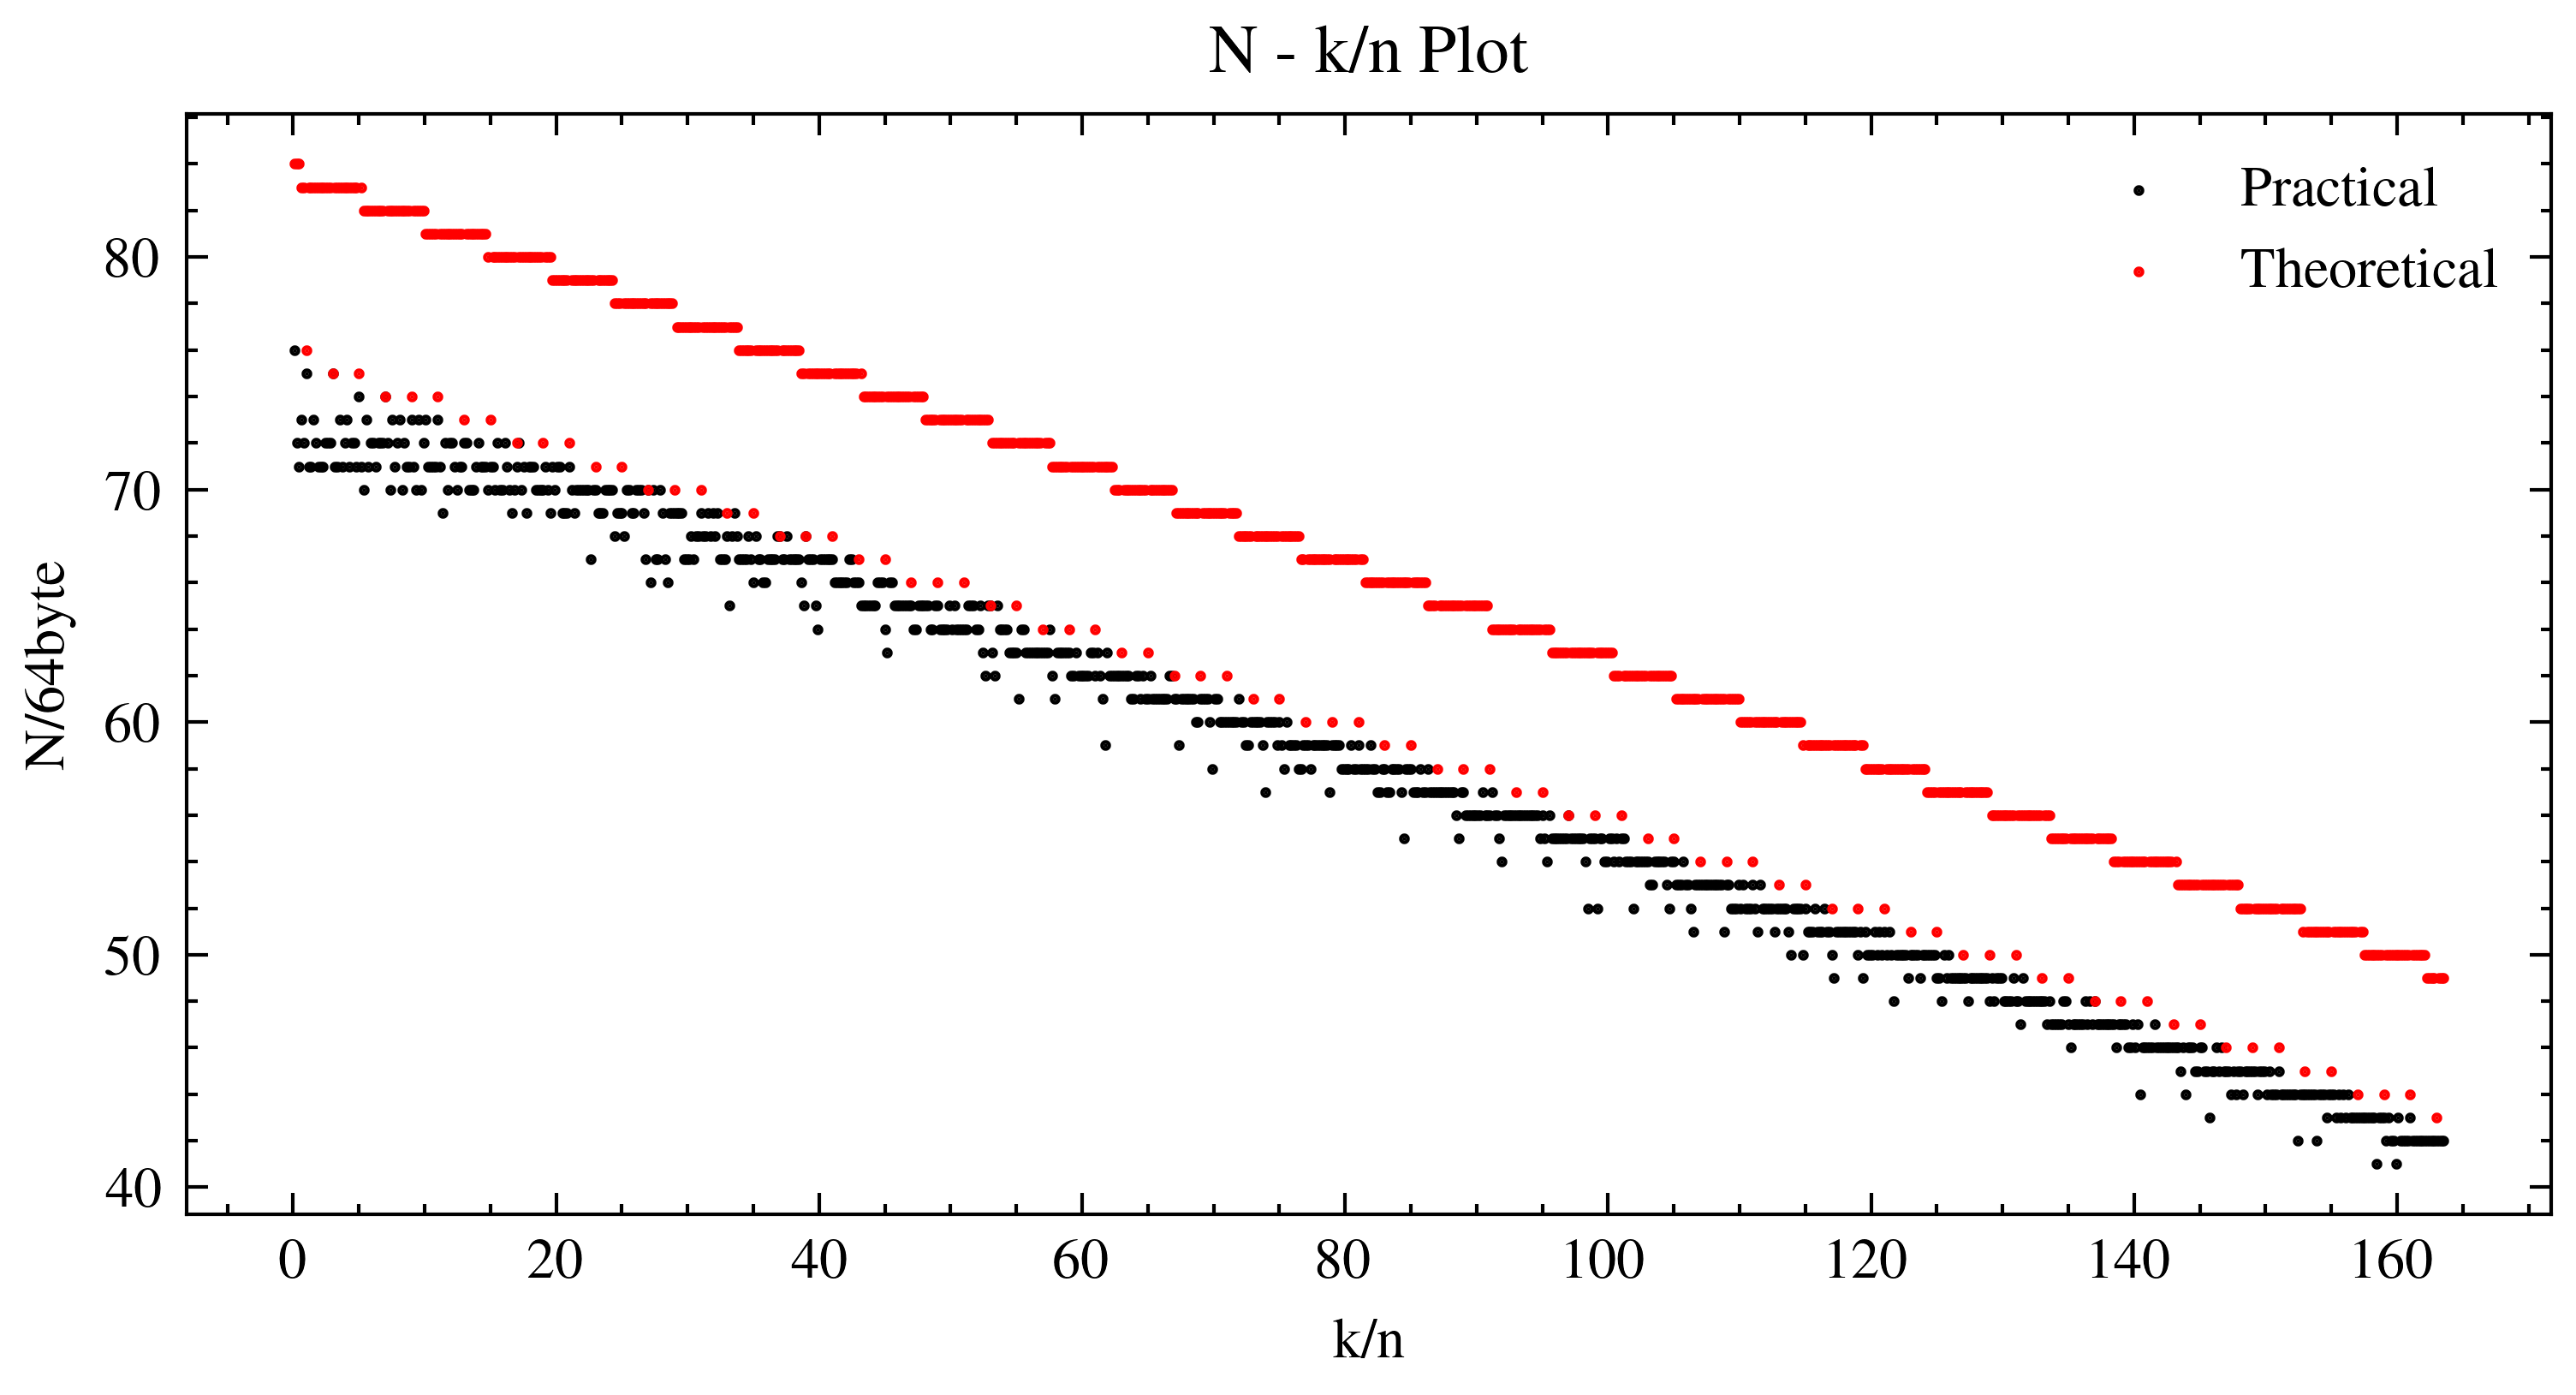

In [ ]:
show_real_use_of_n_fifo_plot(k_times = 1800, t_start_times = 1, step=2)

In [ ]:
def t_and_n_fifo(N = 7, K = 1, t_start = 300e-9, n_seq = 20, t = 27e-5):
    d = {'t': [], 'n_fifo': []}
    # r = sympy.Rational(K, N)
    # K = r.p
    # N = r.q

    S_OUT = (N * T_REFI - K * T_SW - N * T_RTI) / \
                (N * T_REFI) * S_IN  # 64byte
    T_SEQ = (N * T_REFI - K * T_SW - N * T_RTI) / K  # sec
    N_SEQ = math.ceil(T_SEQ * S_IN)  # 64byte
        

    N_FIFO = math.ceil(
        T_SW * S_OUT + (T_SW * S_OUT + T_SW * S_IN + T_RTI * S_OUT if N != 1 else T_RTI * S_OUT)
    )  + 1

    d['t'].append(0)
    d['n_fifo'].append(N_FIFO)

    wfm_64byte_array = [N_SEQ for i in range(n_seq)]
    fifo_in_interval = 1 / S_IN
    fifo_out_interval = 1 / S_OUT

    ddr_sdram = Sdram(wfm_64byte_array)
    fifo = Fifo(N_FIFO)
    clock = Clock(fifo_in_interval, fifo_out_interval,
                T_REFI, T_SW, T_RTI, t_start)

    try:
        while(not ddr_sdram.get_finished_tranfer()):
            clock.run()
            fin = clock.fifo_in_finish()
            fout = clock.fifo_out_finish()
            ffull = fifo.is_full()

            if fin and (not ffull):
                ddr_sdram.send_out()
                fifo.receive_in()

                if ddr_sdram.get_in_sw():
                    clock.set_sw()

            if fout:
                fifo.send_out()

            cur_fifo_n = fifo.get_n_64byte_fifo_current()

            ## t时结束
            if(clock.get_current_t() > t):
                break

            d['n_fifo'].append(cur_fifo_n)
            d['t'].append(clock.get_current_t())
    except FifoEmpty:
        print("t_start:  %.5fns" % (t_start * 1e9))
        print("K / N:  {}".format(r))
        print("n_seq:  %d" % n_seq)
        print("n_refi:  %d" % (clock.get_current_cycle_num()))
        print("current_t:  %.5fns" % (clock.get_current_t_in_refi()))
        sys.exit()

    # plt.style.use(['science','ieee'])
    # fig, ax = plt.subplots()
    x = np.array(d['t'])
    y = np.array(d['n_fifo'])
    # ax.set_xlabel("T/s")
    # ax.set_ylabel("N/64byte")
    # plt.show()
    return {"x":x, "y":y}
    

In [ ]:
def plot_t_n_fifo(N = 7, K = 1, t_start = 300e-9, n_seq = 2):
    d = t_and_n_fifo(N=N, K=K,t_start = t_start, n_seq = n_seq)
    plt.style.use(['science','ieee'])
    fig, ax = plt.subplots(figsize=(7, 3.5))
    ax.set_xlabel("T/s")
    ax.set_ylabel("N/64byte")
    ax.plot(d["x"], d["y"], lw=0.5)
    plt.show()

In [ ]:
T_SW = math.ceil((60e-9) / T_IN) * T_IN
T_RTI = math.ceil((360e-9) / T_IN) * T_IN
# plot_t_n_fifo(10000,224375, n_seq = 2000)
adden = T_REFI / 6000
for i in range(6000):
    t_and_n_fifo(10000,224375, n_seq = 20000, t_start=i * adden)

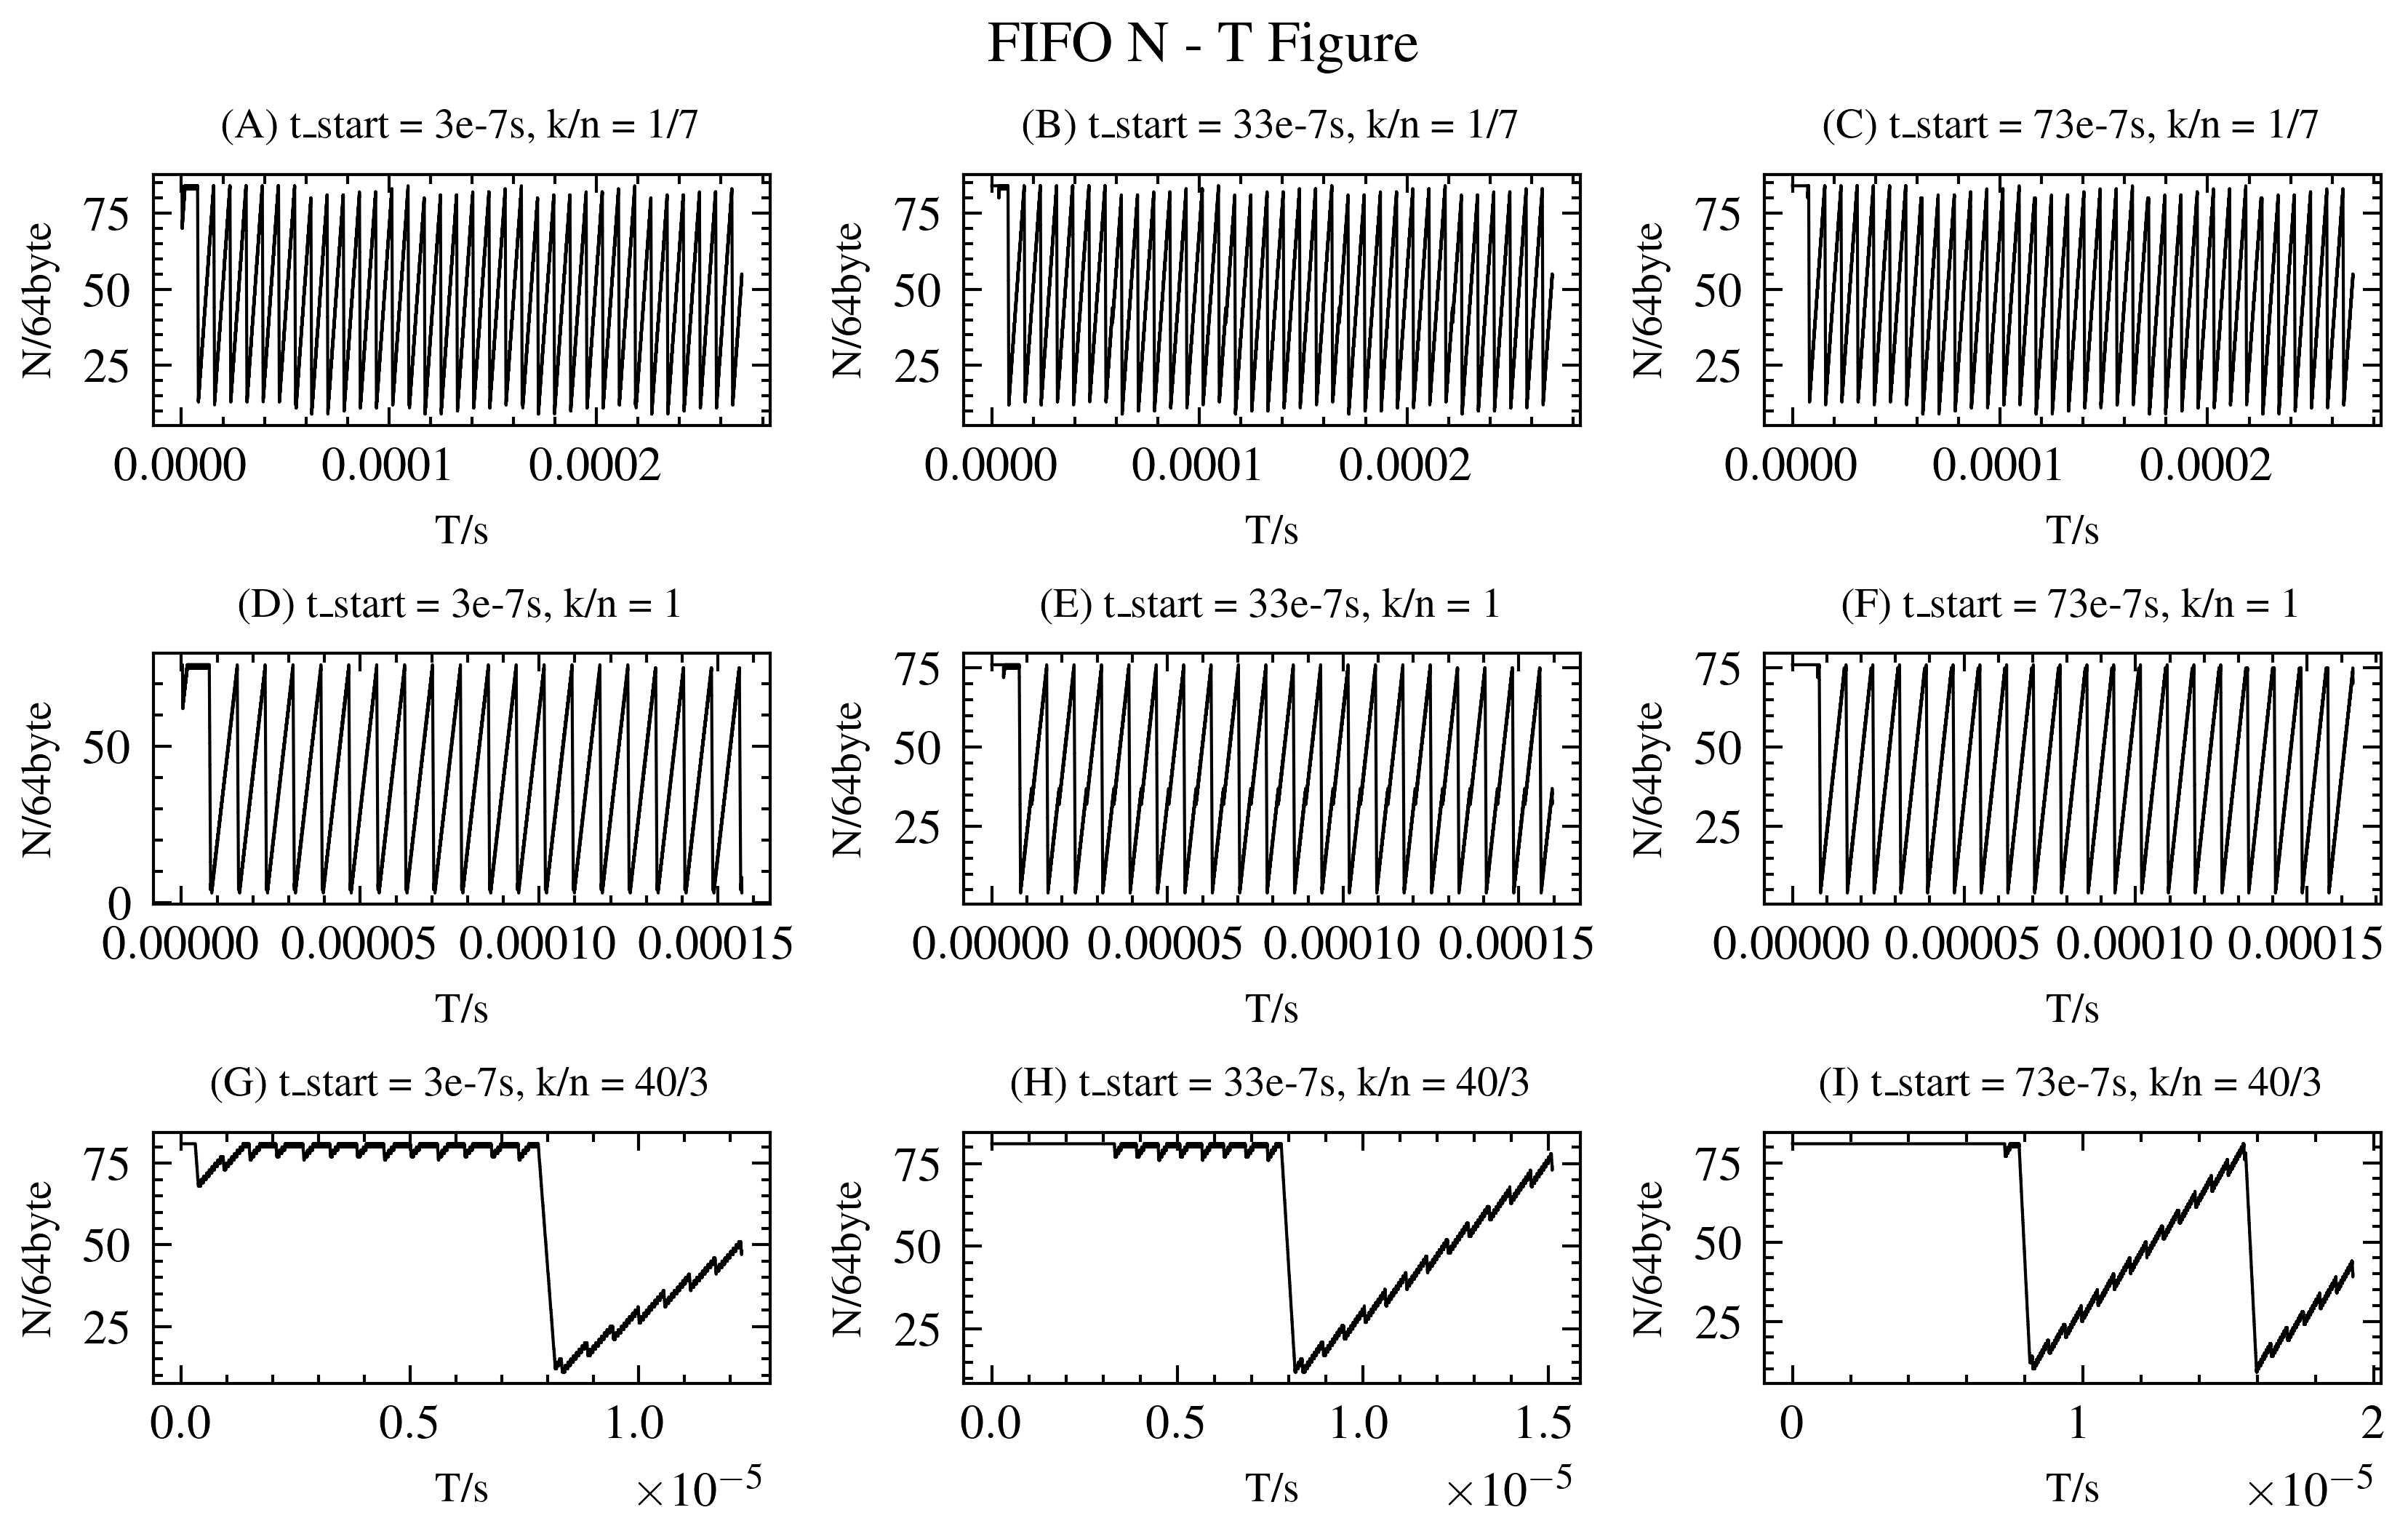

In [ ]:
plt.style.use(['science','ieee'])
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(5.5, 3.5),
                        layout="constrained")
data = [[None for i in range(3)] for i in range(3)]
data[0][0] = t_and_n_fifo(7, 1, 3e-7)
data[0][1] = t_and_n_fifo(7, 1, 33e-7)
data[0][2] = t_and_n_fifo(7, 1, 73e-7)
data[1][0] = t_and_n_fifo(1, 1, 3e-7)
data[1][1] = t_and_n_fifo(1, 1, 33e-7)
data[1][2] = t_and_n_fifo(1, 1, 73e-7)
data[2][0] = t_and_n_fifo(3, 40, 3e-7)
data[2][1] = t_and_n_fifo(3, 40, 33e-7)
data[2][2] = t_and_n_fifo(3, 40, 73e-7)

data[0][0]["title"] = "(A) t_start = 3e-7s, k/n = 1/7"
data[0][1]["title"] = "(B) t_start = 33e-7s, k/n = 1/7"
data[0][2]["title"] = "(C) t_start = 73e-7s, k/n = 1/7"
data[1][0]["title"] = "(D) t_start = 3e-7s, k/n = 1"
data[1][1]["title"] = "(E) t_start = 33e-7s, k/n = 1"
data[1][2]["title"] = "(F) t_start = 73e-7s, k/n = 1"
data[2][0]["title"] = "(G) t_start = 3e-7s, k/n = 40/3"
data[2][1]["title"] = "(H) t_start = 33e-7s, k/n = 40/3"
data[2][2]["title"] = "(I) t_start = 73e-7s, k/n = 40/3"

for row in range(3):
    for col in range(3):
        ax = axs[row][col]
        d = data[row][col]
        ax.plot(d["x"], d['y'], lw=0.5)
        ax.set_xlabel("T/s", fontsize=7)
        ax.set_ylabel("N/64byte", fontsize=7)
        ax.set_title(d["title"], fontsize=7)
fig.suptitle("FIFO N - T Figure")
plt.show()


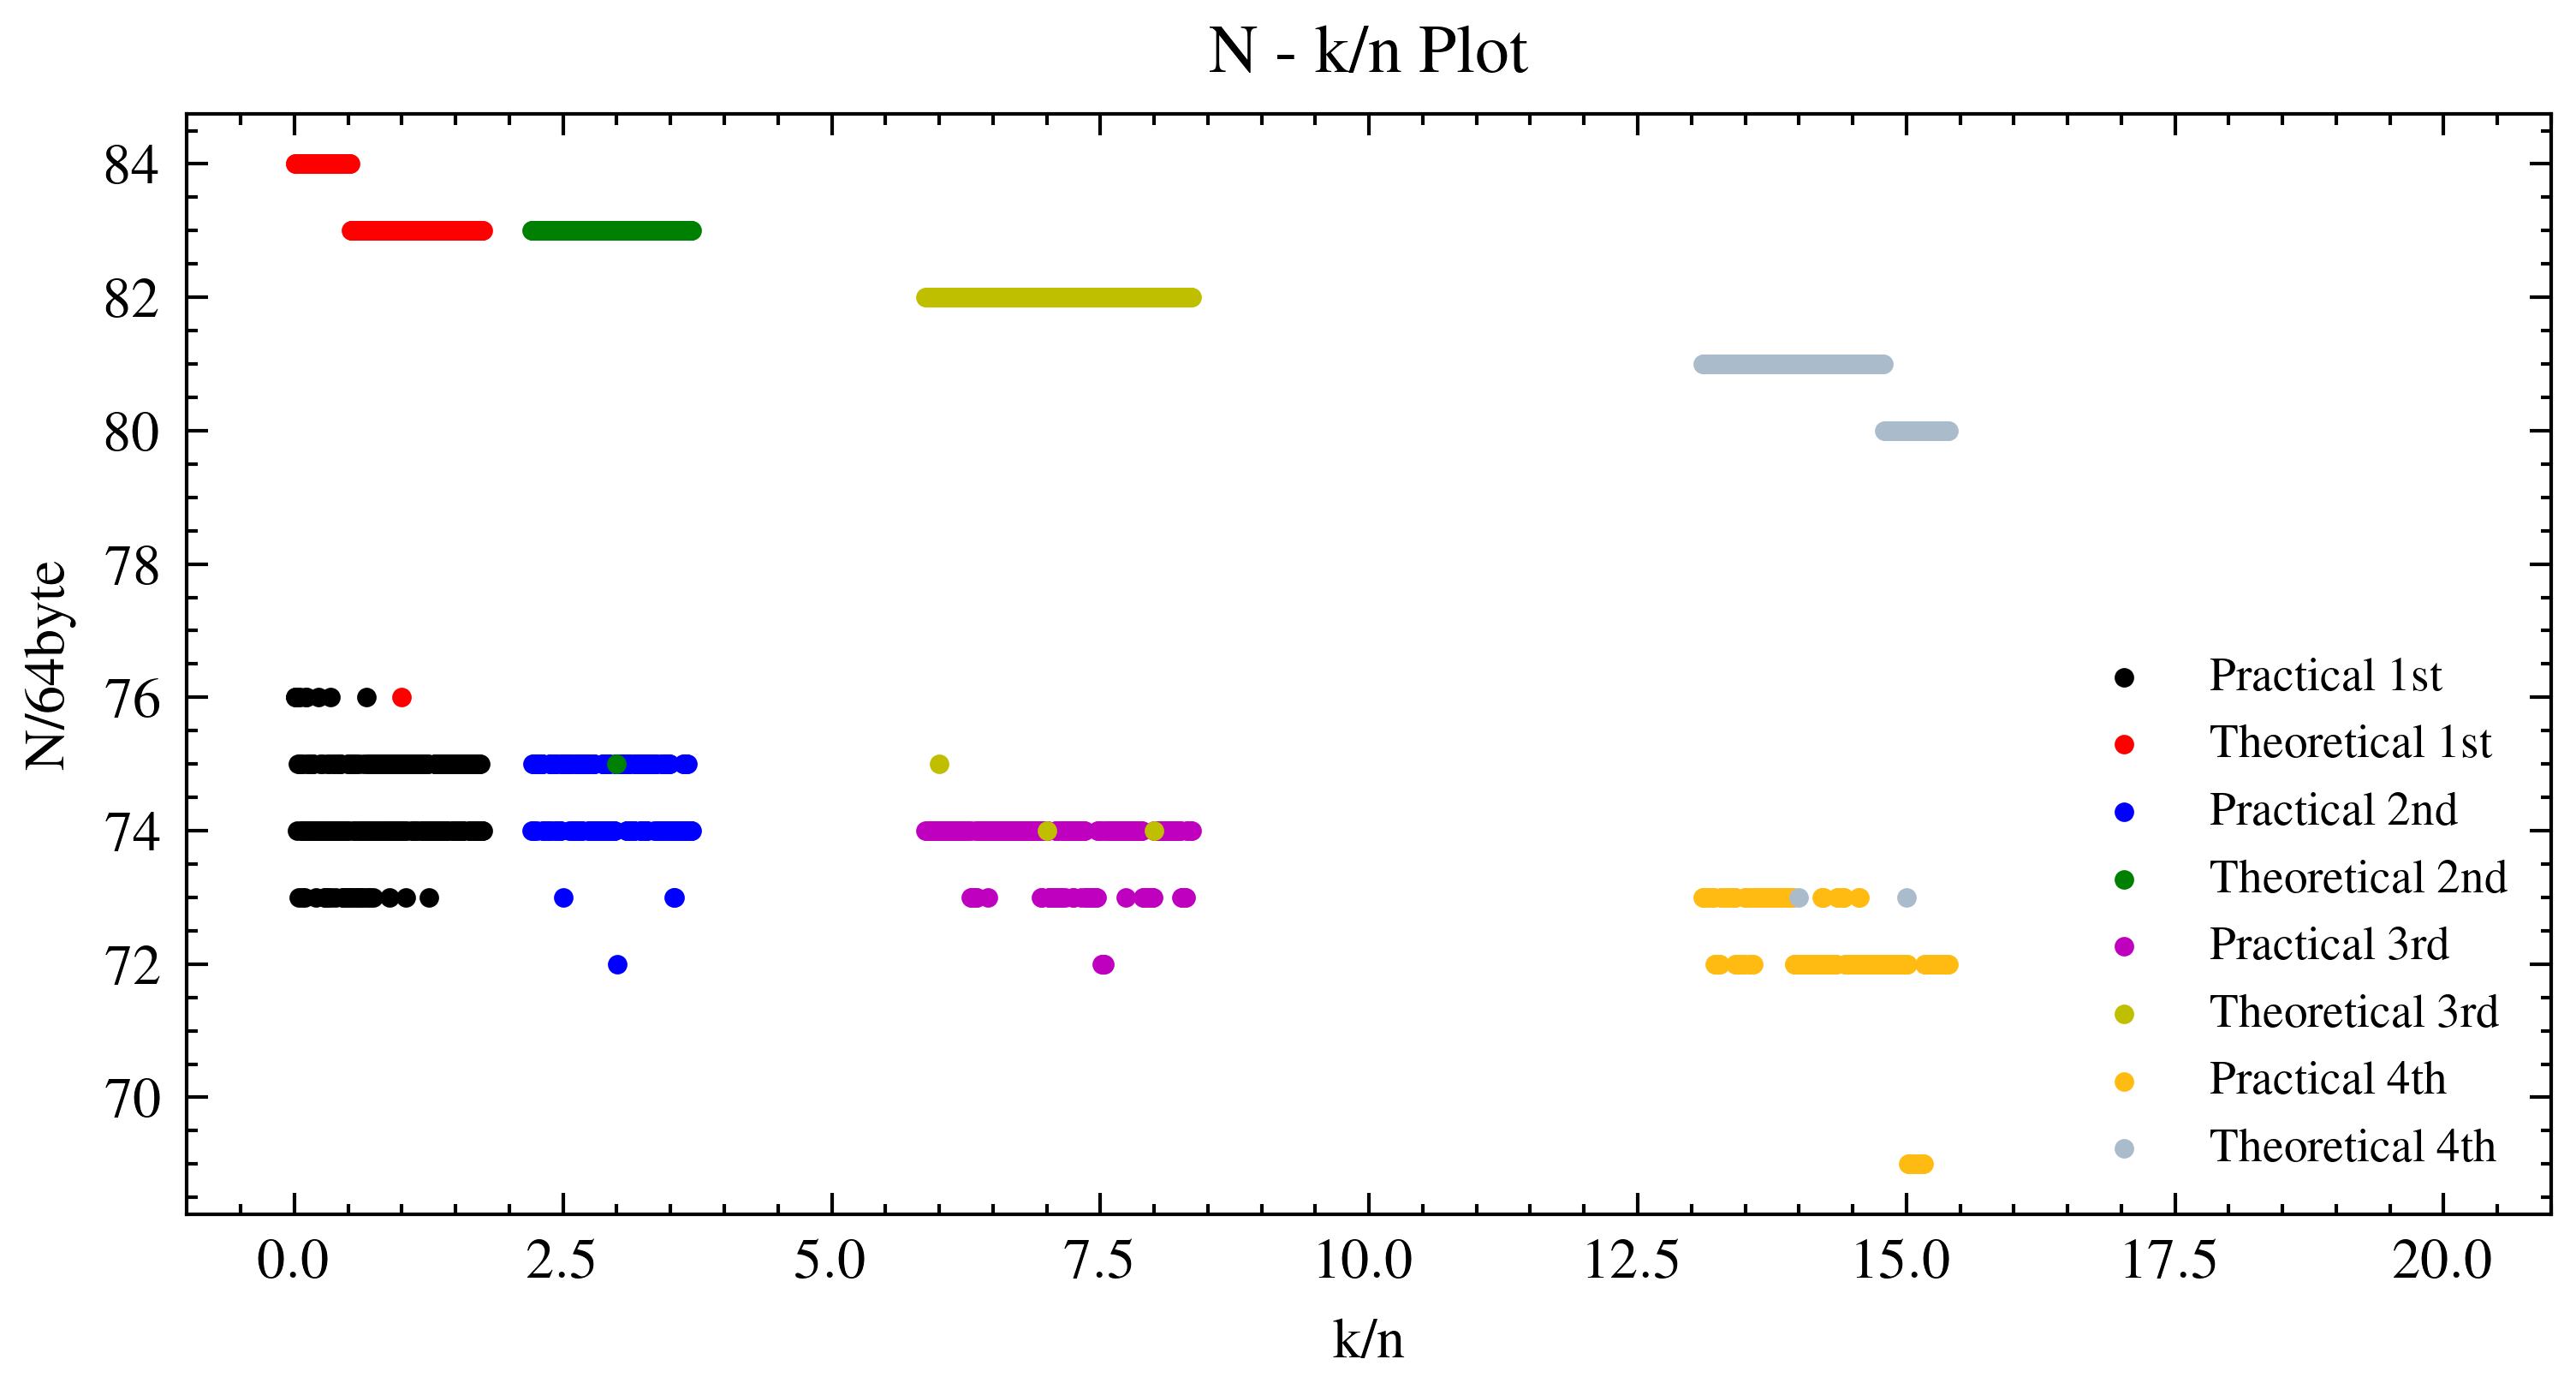

In [ ]:
def real_use_of_n_fifo(N = 11, K = 1, k_times = 300, t_start_times = 300):
    plt.style.use(['science','ieee'])
    # d = {'k/n': [], 'n_fifo': [], "type": []}
    d = {'k/n': [], 'n_practical': [], 'n_theoretical': []}
    # type: 1.Theoretical 2.Practical
    k1 = K
    n1 = N
    for i in range(k_times):
        K = k1 + i
        N = n1

        r = sympy.Rational(K, N)
        K = r.p
        N = r.q

        S_OUT = (N * T_REFI - K * T_SW - N * T_RTI) / \
                (N * T_REFI) * S_IN  # 64byte
        T_SEQ = (N * T_REFI - K * T_SW - N * T_RTI) / K  # sec
        N_SEQ = math.ceil(T_SEQ * S_IN)  # 64byte
        

        N_FIFO = math.ceil(
            T_SW * S_OUT + (T_SW * S_OUT + T_SW * S_IN + T_RTI * S_OUT if N != 1 else T_RTI * S_OUT)
        ) + 1

        d['k/n'].append(K / N)
        d['n_theoretical'].append(N_FIFO)
        # d['type'].append("Theoretical")

        n_seq = math.ceil(N_NUM / N_SEQ)
        wfm_64byte_array = [N_SEQ for i in range(n_seq)]
        fifo_in_interval = 1 / S_IN
        fifo_out_interval = 1 / S_OUT

        n_min = N_FIFO
        t_start = 0
        for j in range(t_start_times):
            t_start += T_REFI / t_start_times
            ddr_sdram = Sdram(wfm_64byte_array)
            fifo = Fifo(N_FIFO)
            clock = Clock(fifo_in_interval, fifo_out_interval,
                        T_REFI, T_SW, T_RTI, t_start)

            try:
                while(not ddr_sdram.get_finished_tranfer()):
                    clock.run()
                    fin = clock.fifo_in_finish()
                    fout = clock.fifo_out_finish()
                    ffull = fifo.is_full()

                    if fin and (not ffull):
                        ddr_sdram.send_out()
                        fifo.receive_in()

                        if ddr_sdram.get_in_sw():
                            clock.set_sw()

                    if fout:
                        fifo.send_out()

                    cur_fifo_n = fifo.get_n_64byte_fifo_current()
                    n_min = min(cur_fifo_n, n_min)
            except FifoEmpty:
                print("t_start:  %.5fns" % (t_start * 1e9))
                print("K / N:  {}".format(r))
                print("n_seq:  %d" % n_seq)
                print("n_refi:  %d" % (clock.get_current_cycle_num()))
                print("current_t:  %.5fns" % (clock.get_current_t_in_refi()))
                sys.exit()

        # d['k/n'].append(K / N)
        d['n_practical'].append(N_FIFO - n_min)
        # d['type'].append("Practical")

    # df = pd.DataFrame(data=d)
    # sns.set_theme()
    # sns.relplot(data=df, x="k/n", y="n_fifo", hue="type", style="type",kind="scatter")
    kn = np.array(d['k/n'])
    n_pa = np.array(d['n_practical'])
    n_th = np.array(d['n_theoretical'])

    # return {"kn": kn, "n_pa": n_pa, "n_th":n_th}
    return [kn, n_pa, n_th]

fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')

[kn, n_pa, n_th] = real_use_of_n_fifo(N = 171, K = 1, k_times = 300, t_start_times = 30)
ax.scatter(kn, n_pa, label="Practical 1st", s = 3)
ax.scatter(kn, n_th, label="Theoretical 1st", s = 3)

[kn, n_pa, n_th] = real_use_of_n_fifo(N = 201, K = 444, k_times = 300, t_start_times = 30)
ax.scatter(kn, n_pa, label="Practical 2nd", s = 3)
ax.scatter(kn, n_th, label="Theoretical 2nd", s = 3)

[kn, n_pa, n_th] = real_use_of_n_fifo(N = 121, K = 711, k_times = 300, t_start_times = 30)
ax.scatter(kn, n_pa, c = 'm', label="Practical 3rd", s = 3)
ax.scatter(kn, n_th, c = 'y', label="Theoretical 3rd", s = 3)

[kn, n_pa, n_th] = real_use_of_n_fifo(N = 131, K = 1717, k_times = 300, t_start_times = 30)
ax.scatter(kn, n_pa,c = "#ffbb11", label="Practical 4th", s = 3)
ax.scatter(kn, n_th, c = "#aabbcc",label="Theoretical 4th", s = 3)

ax.set_ylabel("N/64byte")
ax.set_xlabel("k/n")
ax.set_title("N - k/n Plot")
plt.xlim(-1, 21)
plt.legend(loc='lower right', fontsize='small')
plt.show()